# Package Imports

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from time import time
from scipy.special import comb
from math import comb as nCk
from icol.icol import *

wd = os.getcwd()

In [2]:
print(wd)
os.chdir('../')

print(wd)

/home/simon/Documents/Research/icol/Analysis
/home/simon/Documents/Research/icol/Analysis


# Result Loading

In [3]:
out_dir = os.path.join(os.getcwd(), 'Output')

oracle_out_dir = os.path.join(os.getcwd(), 'Output', 'Polynomial_Oracle_Exps')
for root, dirs, files in os.walk(oracle_out_dir):
    for i, f in enumerate(files):
        path = os.path.join(oracle_out_dir, f)
        df_i = pd.read_csv(path)
        if i == 0:
            oracle_df = df_i
        else:
            oracle_df = oracle_df.append(df_i, ignore_index=True)

N = oracle_df['n'].unique()
P = oracle_df['p'].unique()
D = oracle_df['d'].unique()
SO = oracle_df['so'].unique()
RS = oracle_df['random_state'].unique()
REPS = oracle_df['rep'].unique()


N.sort()
P.sort()
D.sort()
RS.sort()
REPS.sort()
SO.sort()

S_grid_all_used = oracle_df['s'].unique()
len(oracle_df)
SO, N, P, D, RS, REPS, S_grid_all_used

(array(['AdaLASSO(gamma=1)', 'L0', 'LASSO', 'Lars', 'TLS'], dtype=object),
 array([   10.,    20.,    50.,   100.,   200.,   500.,  1000.,  2000.,
         5000., 10000.]),
 array([1.0000e+01, 6.5000e+01, 2.8500e+02, 1.0000e+03, 3.0020e+03,
        8.0070e+03, 1.9447e+04]),
 array([1., 2., 3., 4., 5., 6., 7.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([1.e+00, 2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00,
        9.e+00, 1.e+01, 2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01,
        8.e+01, 9.e+01, 1.e+02, 2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02,
        7.e+02, 8.e+02, 9.e+02, 1.e+03, 2.e+03, 3.e+03]))

# Global Plotting Constants

In [4]:
c = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan','black']

C_DICT = {
    'AdaptiveLASSO': 'blue',
    'AdaLASSO(gamma=1)': 'blue',
    'AdaLASSO': 'blue',
    'LASSO': 'orange',
    'Lasso': 'orange',
    'L0': 'green',
    'BSS': 'green',
    'TLS': 'red',
    'ThresholdedLeastSquares': 'red',
    'Lars': 'purple',
    'LARS': 'purple'
}

lw = 5
ls = ['solid', 'dashed']
hbuffer = 0
vbuffer = 0
plot_size = 7
fontsize=24
out_legend=True

# Determine $C_0$ & $C_1$

In [5]:
t_max = 30
t_min = 0.1

# t_min = max(0.1, t_min_las, t_min_l0, t_min_ada)

kmax = 5
nmax = 10000
pmax = 19477

X = np.array([
    [1, 1],
    [1, kmax*nmax*pmax]
])
y = np.array([
    [t_min],
    [t_max]
])

c0, c1 = np.linalg.solve(X, y)
c0, c1, c0 + c1*kmax*nmax*pmax, c0+c1

(array([0.09999997]), array([3.07028804e-08]), array([30.]), array([0.1]))

# Determine $d_0$ & $\textbf{d}$

In [6]:
from scipy.special import binom

base_terms = lambda k, n, p, s: np.array([k*n, k*n*p, k*s + k*(k+1)/2])
las_terms = lambda k, n, p, s: np.array([n*s*k**2, k**3])
ala_terms = lambda k, n, p, s: np.array([n*s*k**2, k**3, n*(s*k)**2, (s*k)**3])
bss_terms = lambda k, n, p, s: binom(s*k, k)*np.array([n*k**2, k**3])

def cost(df, base_cost, so_cost, so):
    time_arr = df[df['so']==so][['k', 'n', 'p', 's', 'fit_time']].values
    num_base = len(base_cost(0,0,0,0))
    num_so = len(so_cost(0,0,0,0))
    X = np.zeros(shape = (len(time_arr), num_base+num_so))
    y = np.zeros(shape = len(time_arr))
    for i in range(len(time_arr)):
        b = base_cost(k=time_arr[i, 0], n=time_arr[i, 1], p=time_arr[i, 2], s=time_arr[i, 3])
        s = np.zeros(num_so)
        for l in range(1, 1+int(time_arr[i, 0])):
            s += so_cost(k=l, n=time_arr[i, 1], p=time_arr[i, 2], s=time_arr[i, 3])
        X[i, :] = np.hstack([b, s])
        y[i] = time_arr[i, 4]
    d0 = y.mean()
    y -= d0
    d, res, rank, singular = np.linalg.lstsq(X, y, rcond=False)
    return d0, d

In [7]:
d0_las, d_las = cost(df=oracle_df, base_cost=base_terms, so_cost=las_terms, so='LASSO')
d0_ala, d_ala = cost(df=oracle_df, base_cost=base_terms, so_cost=ala_terms, so='AdaLASSO(gamma=1)')
d0_bss, d_bss = cost(df=oracle_df, base_cost=base_terms, so_cost=bss_terms, so='L0')
d0_tls, d_tls = cost(df=oracle_df, base_cost=base_terms, so_cost=ala_terms, so='TLS')
d0_lar, d_lar = cost(df=oracle_df, base_cost=base_terms, so_cost=ala_terms, so='Lars')

In [8]:
def complexity_gen(base, so, d0, d):
    def complexity(k, n, p, s):
        so_cost = np.zeros(len(so(0,0,0,0)))
        for l in range(1, k+1):
            so_cost += so(k=l, n=n, p=p, s=s)
        return np.dot(d, np.hstack([base(k, n, p, s), so_cost])) + d0
    return complexity

las_comp = complexity_gen(base=base_terms, so=las_terms, d0=d0_las, d=d_las)
ala_comp = complexity_gen(base=base_terms, so=ala_terms, d0=d0_ala, d=d_ala)
bss_comp = complexity_gen(base=base_terms, so=bss_terms, d0=d0_bss, d=d_bss)
tls_comp = complexity_gen(base=base_terms, so=ala_terms, d0=d0_tls, d=d_tls)
lar_comp = complexity_gen(base=base_terms, so=ala_terms, d0=d0_lar, d=d_lar)

# Finding $S_{\max}$

In [9]:
def find_s_max(comp, c0, c1, k, n, p, S_grid = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000,2000,3000]):
    found = False
    s_max = 1
    i = 0
    while (not found) and (i<len(S_grid)):
        s = S_grid[-(i+1)]
        s_next = 1 if i < len(S_grid) else S_grid[-(i+2)]
        if comp(k=k, n=n, p=p, s=s) <= c0 + c1*k*n*p:
            if s*k <= p:
                s_max = s
                found = True
        i += 1
    return s_max

In [10]:
S_grid = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000,2000,3000,4000]
k =5
comp_dict = {
    'AdaLASSO(gamma=1)': ala_comp,
    'AdaptiveLASSO': ala_comp,
    'AdaLASSO': ala_comp,
    'LASSO': las_comp,
    'Lasso': las_comp,
    'L0': bss_comp,
    'BSS': bss_comp,
    'TLS': tls_comp,
    'ThresholdedLeastSquares': tls_comp,
    'Lars': lar_comp,
    'LARS': lar_comp,
}

In [11]:
find_s_max(comp = lar_comp, c0=c0, c1=c1, k=5, n=10000, p=1000, S_grid=S_grid)

200

In [12]:
s_max_emp = np.zeros(shape=(len(N), len(P), len(SO)))
s_max_act = np.zeros_like(s_max_emp)
for i, n in enumerate(N):
    for j, p in enumerate(P):
        for q, so in enumerate(SO):
            print(n, p, so)
            vals = oracle_df[(oracle_df['n']==n)&(oracle_df['p']==p)&(oracle_df['so']==so)&(oracle_df['random_state']==0)&(oracle_df['rep']==0)]['s'].values
            if len(vals)>0:
                s_max_act[i, j, q] = max(vals)
            else:
                s_max_act[i, j, q] = -1
            s_max_emp[i,j,q] = find_s_max(comp = comp_dict[so], c0=c0, c1=c1, k=5, n=n, p=p, S_grid=S_grid)


10.0 10.0 AdaLASSO(gamma=1)
10.0 10.0 L0
10.0 10.0 LASSO
10.0 10.0 Lars
10.0 10.0 TLS
10.0 65.0 AdaLASSO(gamma=1)
10.0 65.0 L0
10.0 65.0 LASSO
10.0 65.0 Lars
10.0 65.0 TLS
10.0 285.0 AdaLASSO(gamma=1)
10.0 285.0 L0
10.0 285.0 LASSO
10.0 285.0 Lars
10.0 285.0 TLS
10.0 1000.0 AdaLASSO(gamma=1)
10.0 1000.0 L0
10.0 1000.0 LASSO
10.0 1000.0 Lars
10.0 1000.0 TLS
10.0 3002.0 AdaLASSO(gamma=1)
10.0 3002.0 L0
10.0 3002.0 LASSO
10.0 3002.0 Lars
10.0 3002.0 TLS
10.0 8007.0 AdaLASSO(gamma=1)
10.0 8007.0 L0
10.0 8007.0 LASSO
10.0 8007.0 Lars
10.0 8007.0 TLS
10.0 19447.0 AdaLASSO(gamma=1)
10.0 19447.0 L0
10.0 19447.0 LASSO
10.0 19447.0 Lars
10.0 19447.0 TLS
20.0 10.0 AdaLASSO(gamma=1)
20.0 10.0 L0
20.0 10.0 LASSO
20.0 10.0 Lars
20.0 10.0 TLS
20.0 65.0 AdaLASSO(gamma=1)
20.0 65.0 L0
20.0 65.0 LASSO
20.0 65.0 Lars
20.0 65.0 TLS
20.0 285.0 AdaLASSO(gamma=1)
20.0 285.0 L0
20.0 285.0 LASSO
20.0 285.0 Lars
20.0 285.0 TLS
20.0 1000.0 AdaLASSO(gamma=1)
20.0 1000.0 L0
20.0 1000.0 LASSO
20.0 1000.0 Lars
20.0 

# $s$ that we accidentally skipped

In [13]:
S_grid = np.array(S_grid)
for i, n in enumerate(N):
    for j, p in enumerate(P):
        for q, so in enumerate(SO):
            if s_max_act[i,j,q] < s_max_emp[i,j,q]:
                S_todo = S_grid[(S_grid > s_max_act[i,j,q])&(S_grid <= s_max_emp[i,j,q])]
                if not((p in [P[-2], P[-1]] and so == 'Lars') or (p in [P[-1]] and so == 'TLS')):
                    print('n={0}, p={1}, so={2}, S={3}'.format(n,p,so, S_todo))

In [14]:
overtime_df = oracle_df[oracle_df['fit_time']>t_max]
oracle_df = oracle_df[oracle_df['fit_time']<=t_max]
len(overtime_df), len(oracle_df), overtime_df['fit_time'].max()

(400, 501901, 77.13725137710571)

# Overall Data Efficiency

In [15]:
TOLS = [0.5, 0.25, 0.1]
def best_s_consistency(df, formula, s_max=np.infty, metric='inclusion', zero_eff=1e-14, verbose=False):
    df_rel = df[formula]
    S_rel = df_rel['s'].unique()
    S_rel = S_rel[S_rel<=s_max]
    i = 0
    found = False
    s_star, e_star = S_rel[i], df_rel[df_rel['s']==S_rel[i]][metric].mean()
    while (i < len(S_rel)) and (found == False):
        e = df_rel[df_rel['s']==S_rel[i]][metric].mean()
        if e>=1-zero_eff or (e == 1.0):
            s_star, e_star = S_rel[i], e
            found = True
        elif e > e_star:
            s_star, e_star = S_rel[i], e
        if verbose: print('s={0}, e={1}'.format(s_star, e_star))
        i += 1
    return s_star, e_star, found

In [17]:
res_arr = np.zeros(shape=(len(TOLS), len(D), len(SO)))
                                                 
for q, tol in enumerate(TOLS):
    for i, d in enumerate(D):
        for k, so in enumerate(SO):
            print(tol, d, so)                    
            n_found = False
            j = 0
            while (j < len(N)) and (n_found == False):
                n = N[j]
                found_count = 0
                rep_count = 0
                for random_state in RS:
                    for rep in REPS:
                        formula = (oracle_df['n']==n)&(oracle_df['d']==d)&(oracle_df['so']==so)&(oracle_df['random_state']==random_state)&(oracle_df['rep']==rep)
                        s_max = s_max_emp[j, int(d)-1, k]
                        s_star, e_star, found = best_s_consistency(df=oracle_df, formula=formula, s_max=s_max, metric='inclusion', zero_eff=1e-14)
                        found_count += found
                        rep_count += 1
                p = 1 - (found_count/rep_count)
                if p <= tol:
                    n_found = True
                j += 1
            if n_found:
                res_arr[q, i, k] = n
            else:
                res_arr[q, i, k] = 2*max(N)
            print(res_arr[q,i,k])


0.5 1.0 AdaLASSO(gamma=1)
20.0
0.5 1.0 L0
20.0
0.5 1.0 LASSO
20.0
0.5 1.0 Lars
20.0
0.5 1.0 TLS
20.0
0.5 2.0 AdaLASSO(gamma=1)
20.0
0.5 2.0 L0
100.0
0.5 2.0 LASSO
100.0
0.5 2.0 Lars
100.0
0.5 2.0 TLS
100.0
0.5 3.0 AdaLASSO(gamma=1)
50.0
0.5 3.0 L0
5000.0
0.5 3.0 LASSO
2000.0
0.5 3.0 Lars
2000.0
0.5 3.0 TLS
500.0
0.5 4.0 AdaLASSO(gamma=1)
100.0
0.5 4.0 L0
20000.0
0.5 4.0 LASSO
20000.0
0.5 4.0 Lars
20000.0
0.5 4.0 TLS
20000.0
0.5 5.0 AdaLASSO(gamma=1)
200.0
0.5 5.0 L0
20000.0
0.5 5.0 LASSO
20000.0
0.5 5.0 Lars
20000.0
0.5 5.0 TLS
20000.0
0.5 6.0 AdaLASSO(gamma=1)
500.0
0.5 6.0 L0
20000.0
0.5 6.0 LASSO
20000.0
0.5 6.0 Lars
20000.0
0.5 6.0 TLS
20000.0
0.5 7.0 AdaLASSO(gamma=1)
5000.0
0.5 7.0 L0
20000.0
0.5 7.0 LASSO
20000.0
0.5 7.0 Lars
20000.0
0.5 7.0 TLS
20000.0
0.25 1.0 AdaLASSO(gamma=1)
20.0
0.25 1.0 L0
50.0
0.25 1.0 LASSO
50.0
0.25 1.0 Lars
50.0
0.25 1.0 TLS
50.0
0.25 2.0 AdaLASSO(gamma=1)
50.0
0.25 2.0 L0
200.0
0.25 2.0 LASSO
200.0
0.25 2.0 Lars
200.0
0.25 2.0 TLS
100.0
0.25 3.0 AdaL

In [19]:
df_res_arr = pd.DataFrame()
for i, tol in enumerate(TOLS):
    for j, d in enumerate(D):
        for k, so in enumerate(SO):
            n_min = res_arr[i,j,k]
            row = {'tol': tol, 'd': d,
                    'so': so, 'n_min': n_min}
            df_res_arr = df_res_arr.append(row, ignore_index=True)
df_res_arr.to_csv('n_min_oracle.csv')
df_res_arr[(df_res_arr['tol']==0.5)&(df_res_arr['d']==7)]

,tol,d,so,n_min
30,0.5,7.0,AdaLASSO(gamma=1),5000.0
31,0.5,7.0,L0,20000.0
32,0.5,7.0,LASSO,20000.0
33,0.5,7.0,Lars,20000.0
34,0.5,7.0,TLS,20000.0


In [20]:
def plot_polynomial_oracle_sel(res_arr, D, SO, TOLS, c=c,
                               n_max=10000, fontsize=24, out_legend=out_legend,
                               hbuffer = vbuffer, vbuffer = vbuffer, plot_size = plot_size):

    # n_min = r'$ n^\delta_\min = \min \{n \with p_\mathrm{succ}^{(n)} \geq 1-\delta \} $'
    # p_succ = r'$p^{(n)}_\mathrm{succ} = P(\{\hat{I}_{s,n} = I_* \with s \leq s_\mathrm{max}(k,n,p)\})$'

    n_min = r'$ n^\delta_\min $'
    p_succ = r'$p^{(n)}_\mathrm{succ}$'

    P = [10, 65, 285, 1000, 3002, 8008, 19477]

    fig, axs = plt.subplots(1, len(TOLS), sharex=True, sharey=True)
    fig.set_figwidth(len(TOLS)*plot_size+hbuffer)
    fig.set_figheight(plot_size+vbuffer)

    for i, tol in enumerate(TOLS):
        for j, so in enumerate(SO):
            n_vect = res_arr[i, :, j]
            if i == 0:
                if not(so in ['TLS', 'Lars']):
                    axs[i].plot(D[(n_vect < n_max*2) & (n_vect > 0)], n_vect[(n_vect < n_max*2) & (n_vect > 0)], ls = 'solid', label=('BSS' if so == 'L0' else so) if so!='AdaLASSO(gamma=1)' else 'AdaLASSO', c=C_DICT[so], lw=5)
                else:
                    axs[i].plot(D[(n_vect < n_max*2) & (n_vect > 0)], n_vect[(n_vect < n_max*2) & (n_vect > 0)], ls = 'solid', c=C_DICT[so], lw=5)
            elif i==1:
                if so in ['TLS', 'Lars']:
                    axs[i].plot(D[(n_vect < n_max*2) & (n_vect > 0)], n_vect[(n_vect < n_max*2) & (n_vect > 0)], ls = 'solid', label=('BSS' if so == 'L0' else so) if so!='AdaLASSO(gamma=1)' else 'AdaLASSO', c=C_DICT[so], lw=5)
                else:
                    axs[i].plot(D[(n_vect < n_max*2) & (n_vect > 0)], n_vect[(n_vect < n_max*2) & (n_vect > 0)], ls = 'solid', c=C_DICT[so], lw=5)
            else:
                axs[i].plot(D[(n_vect < n_max*2) & (n_vect > 0)], n_vect[(n_vect < n_max*2) & (n_vect > 0)], ls = 'solid', c=C_DICT[so], lw=5)
            axs[i].plot(D[(n_vect > 0)], n_vect[(n_vect > 0)], ls = 'dotted', c=c[j], lw=5)
        if i == 2:
            axs[i].hlines(y=n_max*2, xmin=min(D), xmax=max(D), colors=c[-1], ls='--', lw=5, label=r'$n_{max}$')
            axs[i].scatter(D, P, c='k', label='p', s=100)
        else:
            axs[i].hlines(y=n_max*2, xmin=min(D), xmax=max(D), colors=c[-1], ls='--', lw=5)
            axs[i].scatter(D, P, c='k', s=100)

        axs[i].grid()
        # axs[i].set_title(r'$P\left(I(\beta^*)=I(\hat{\beta_n})\right)$' + ' >= {0}'.format(1-tol), size=36)
        axs[i].set_title(p_succ + r'$\geq$' + '{0}'.format(1-tol), size=fontsize)
        axs[i].tick_params(axis='both', labelsize=fontsize)
        axs[i].set_xticks(D)
        axs[i].set_xlabel('Polynomial Degree (d)', size=fontsize)
        axs[i].set_yscale('log')
        axs[i].margins(x=0.01)
        axs[i].margins(y=0.01)
        axs[i].set_xlim(1, 7)

    axs[0].set_ylabel(n_min, size=fontsize)
#    axs[2].plot(D[0], min(min(N), min(P)), c='k', ls='dotted', lw=5, label=r'$n\geq $' + '{0}'.format(2*n_max))
    axs[2].plot(D[0], min(min(N), min(P)), c='k', ls='dotted', lw=5, label=r'$n^\delta_{\min} \geq n_{\max}$')
    if out_legend:
        lines_labels = [axs[i].get_legend_handles_labels() for i in range(len(TOLS))]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
        fig.legend(lines, labels, loc = 'lower center', 
                   ncol = int(len(lines)//2), fontsize=24,
                   bbox_to_anchor=(0.5, -0.15))
        plt.subplots_adjust(bottom=0.2)
    else:
        for i, tol in enumerate(TOLS):
            axs[i].legend(fontsize=fontsize-4)

    return fig, axs

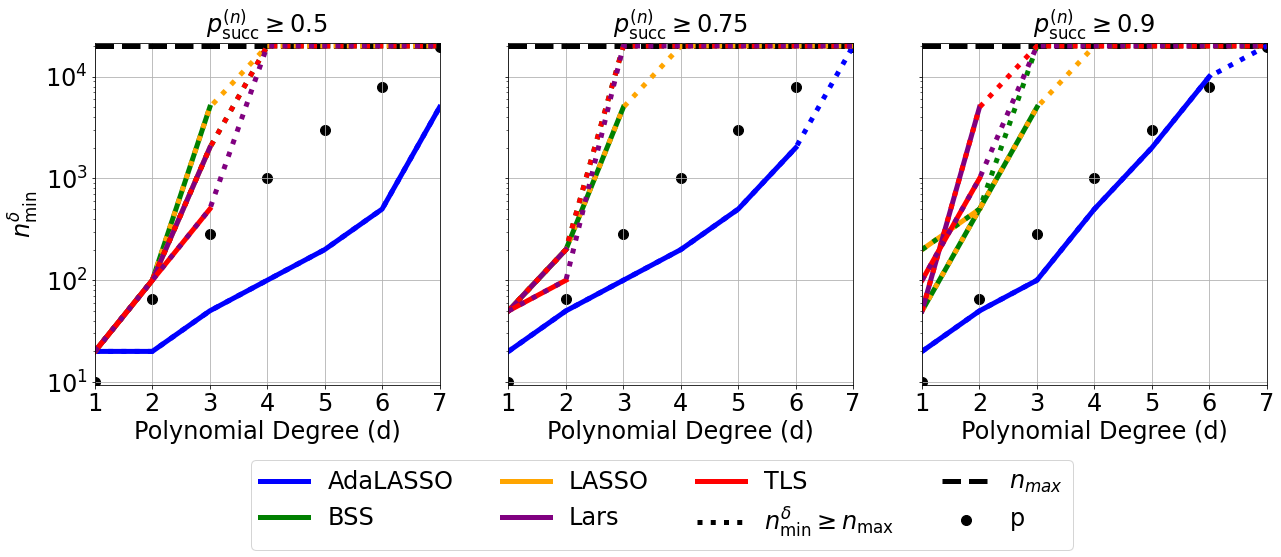

In [ ]:
fig, axs = plot_polynomial_oracle_sel(res_arr=res_arr, D=D, SO=SO, TOLS=[0.5, 0.25, 0.1], c=c, n_max=10000)
#fig.savefig(os.path.join(out_dir, 'polynomial_plots_overleaf', 'selection_consistency_v2.pdf'))

fig.savefig(os.path.join(out_dir, 'plots', 'selection_consistency_5_SOs.pdf'), bbox_inches='tight', pad_inches=0)

# Oracle Selection Per Degree

In [24]:
res_arr_d_v_n = np.zeros(shape=(len(D), len(N), len(SO), 5))
# s_max_emp = np.zeros(shape=(len(N), len(P), len(list(SO_s_check.keys()))))

for i, d in enumerate(D):
    for k, so in enumerate(SO):
        for j, n in enumerate(N):
            print(d, so, n)
            found_count = 0
            rep_count = 0
            s_vect = []
            for random_state in RS:
                if True:
                    for rep in REPS:
                        formula = (oracle_df['n']==n)&(oracle_df['d']==d)&(oracle_df['so']==so)&(oracle_df['random_state']==random_state)&(oracle_df['rep']==rep)
                        s_max = s_max_emp[j, i, k]
                        s_star, e_star, found = best_s_consistency(df=oracle_df, formula=formula, s_max=s_max, metric='inclusion', zero_eff=1e-14)
                        found_count += found
                        rep_count += 1
                        s_vect += [s_star]
                p = found_count/rep_count
                s_vect = np.array(s_vect)
                s_max_formula = (oracle_df['n']==n)&(oracle_df['d']==d)&(oracle_df['so']==so)
                s_max_d_n_so = oracle_df[s_max_formula]['s'].max()
                res_arr_d_v_n[i, j, k] = np.array([p, s_vect.mean(), np.percentile(s_vect, 2.5), np.percentile(s_vect, 97.5), s_max_d_n_so])

1.0 AdaLASSO(gamma=1) 10.0
1.0 AdaLASSO(gamma=1) 20.0
1.0 AdaLASSO(gamma=1) 50.0
1.0 AdaLASSO(gamma=1) 100.0
1.0 AdaLASSO(gamma=1) 200.0
1.0 AdaLASSO(gamma=1) 500.0
1.0 AdaLASSO(gamma=1) 1000.0
1.0 AdaLASSO(gamma=1) 2000.0
1.0 AdaLASSO(gamma=1) 5000.0
1.0 AdaLASSO(gamma=1) 10000.0
1.0 L0 10.0
1.0 L0 20.0
1.0 L0 50.0
1.0 L0 100.0
1.0 L0 200.0
1.0 L0 500.0
1.0 L0 1000.0
1.0 L0 2000.0
1.0 L0 5000.0
1.0 L0 10000.0
1.0 LASSO 10.0
1.0 LASSO 20.0
1.0 LASSO 50.0
1.0 LASSO 100.0
1.0 LASSO 200.0
1.0 LASSO 500.0
1.0 LASSO 1000.0
1.0 LASSO 2000.0
1.0 LASSO 5000.0
1.0 LASSO 10000.0
1.0 Lars 10.0
1.0 Lars 20.0
1.0 Lars 50.0
1.0 Lars 100.0
1.0 Lars 200.0
1.0 Lars 500.0
1.0 Lars 1000.0
1.0 Lars 2000.0
1.0 Lars 5000.0
1.0 Lars 10000.0
1.0 TLS 10.0
1.0 TLS 20.0
1.0 TLS 50.0
1.0 TLS 100.0
1.0 TLS 200.0
1.0 TLS 500.0
1.0 TLS 1000.0
1.0 TLS 2000.0
1.0 TLS 5000.0
1.0 TLS 10000.0
2.0 AdaLASSO(gamma=1) 10.0
2.0 AdaLASSO(gamma=1) 20.0
2.0 AdaLASSO(gamma=1) 50.0
2.0 AdaLASSO(gamma=1) 100.0
2.0 AdaLASSO(gamma=1)

In [38]:
df_d_v_n = pd.DataFrame()
for i, d in enumerate(D):
    for j, n in enumerate(N):
        for k, so in enumerate(SO):
           entry = res_arr_d_v_n[i,j,k]
           row = {
               'd':d,
               'n': n,
               'so': so,
               'p': entry[0],
               's_mean': entry[1],
               's_02_5': entry[2],
               's_97_5': entry[3],
               's_max': entry[4]
               }
           df_d_v_n = df_d_v_n.append(row, ignore_index=True)
df_d_v_n.to_csv('d_v_n_oracle.csv')
df_d_v_n.head()

,d,n,so,p,s_mean,s_02_5,s_97_5,s_max
0,1.0,10.0,AdaLASSO(gamma=1),0.33,140.9,140.225,141.0,3.0
1,1.0,10.0,L0,0.06,91.0,91.000,91.0,1.0
2,1.0,10.0,LASSO,0.13,119.7,119.000,120.0,2.0
3,1.0,10.0,Lars,0.18,132.0,132.000,132.0,2.0
4,1.0,10.0,TLS,0.19,99.9,99.225,100.0,2.0


In [39]:
res_arr_d_v_n_s_star = np.zeros(shape=(len(D), len(N), len(SO), 2))
epsilon = 1e-3
for i, d in enumerate(D):
    print(d)
    for j, n in enumerate(N):
        for k, so in enumerate(SO):
            if True:
                found_count = 0
                rep_count = 0
                formula = (oracle_df['n']==n)&(oracle_df['d']==d)&(oracle_df['so']==so)
                S = oracle_df[formula]['s'].unique()
                s_max = s_max_emp[j, i, k]
                S_valid = S[S<=s_max]
                s_star, p_star = 1, 0
                for q, s in enumerate(S_valid):
                    df_rel = oracle_df[(oracle_df['n']==n)&(oracle_df['d']==d)&(oracle_df['so']==so)&(oracle_df['s']==s)]
                    p = np.mean(df_rel['inclusion'].values>=1-epsilon)
                    if p > p_star:
                        s_star, p_star = s, p
                res_arr_d_v_n_s_star[i, j, k] = np.array([s_star, p_star])

1.0
2.0
3.0
4.0
5.0
6.0
7.0


In [40]:
df_d_vs_n_vs_s_star = pd.DataFrame()
for i, d in enumerate(D):
    for j, n in enumerate(N):
        for k, so in enumerate(SO):
            row = {
                'd': d,
                'n': n,
                'so': so,
                's_star': res_arr_d_v_n_s_star[i,j,k,0],  
                'p_star': res_arr_d_v_n_s_star[i,j,k,1]  
            }
            df_d_vs_n_vs_s_star = df_d_vs_n_vs_s_star.append(row, ignore_index=True)
df_d_vs_n_vs_s_star.head()
df_d_vs_n_vs_s_star.to_csv('d_vs_n_vs_s_star.csv')

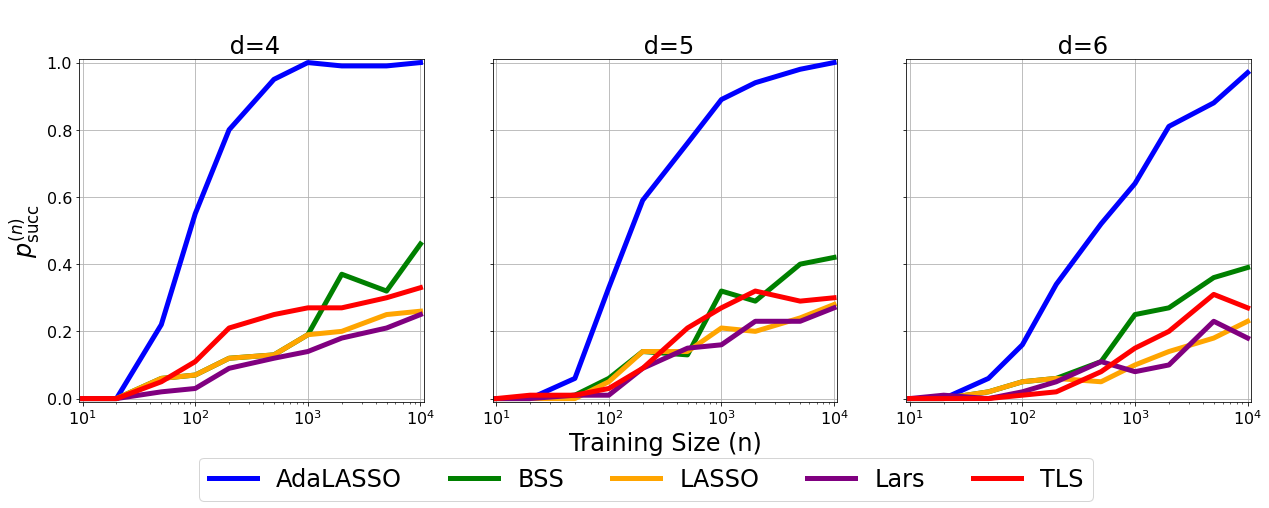

In [ ]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_figheight(plot_size+hbuffer)
fig.set_figwidth(len(axs)*plot_size+vbuffer)
# fig_axs[i,0].suptitle(r'$p(\mathrm{I}(\beta^*) = \mathrm{I}(\hat{\beta}))$' + ' For 10 Polynomials of degree {0}'.format(d), size=20)

# res_arr_d_v_n_s_star = np.empty(shape=(len(D), len(N), len(SO)), dtype=object)

for i, d in enumerate([4,5,6]):
    for j, so in enumerate(SO):
        if True:
            if (d == 4) and not(so in ['Lars', 'TLS']):
                axs[i].plot(N, res_arr_d_v_n[d-1, :, j, 0], lw=5, label=('BSS' if so == 'L0' else so) if so!='AdaLASSO(gamma=1)' else 'AdaLASSO', c=C_DICT[so], ls=ls[0])
            elif (d == 5) and so in ['Lars', 'TLS']:
                axs[i].plot(N, res_arr_d_v_n[d-1, :, j, 0], lw=5, label=('BSS' if so == 'L0' else so) if so!='AdaLASSO(gamma=1)' else 'AdaLASSO', c=C_DICT[so], ls=ls[0])
            else:
                axs[i].plot(N, res_arr_d_v_n[d-1, :, j, 0], lw=5, c=C_DICT[so], ls=ls[0])

            axs[i].tick_params(axis='both', labelsize=fontsize-8)
            axs[i].grid()

            axs[i].set_xscale('log')
            axs[i].margins(x=0.01)
            axs[i].margins(y=0.01)
    axs[0].set_ylabel(r'$p_\mathrm{succ}^{(n)}$', size=fontsize)
    axs[i].set_title('\n d={0}'.format(d), size=fontsize)

axs[1].set_xlabel('Training Size (n)', size=fontsize)
if out_legend:
    lines_labels = [axs[i].get_legend_handles_labels() for i in range(len(axs))]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, loc = 'lower center', 
                ncol = 5, fontsize=24,
               bbox_to_anchor=(0.5, -0.02))
    plt.subplots_adjust(bottom=0.2)
else:
    axs[0].legend(fontsize=fontsize)
    axs[1].legend(fontsize=fontsize)
# axs[0].plot(D[0], min(min(N), min(P)), alpha=0, c='k', ls='dotted', label=r'$n\geq $' + '{0}'.format(2*n_max))

fig.savefig(os.path.join(out_dir, 'plots', 'p_star_v_n_d={0}.pdf'.format(str([4,5,6]))), bbox_inches='tight', pad_inches=0)

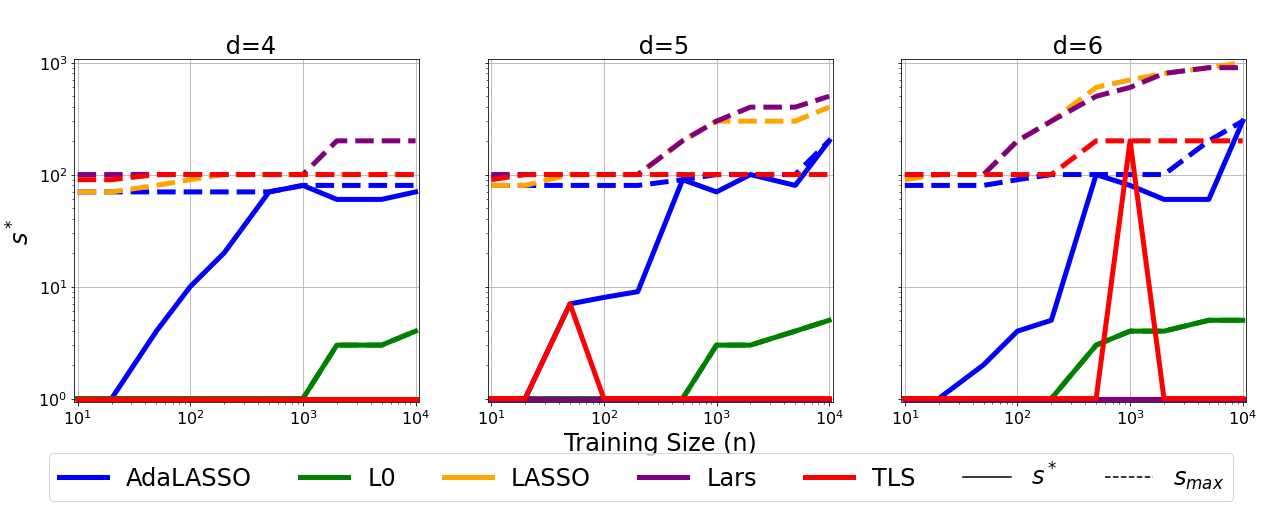

In [ ]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_figheight(plot_size+hbuffer)
fig.set_figwidth(len(axs)*plot_size+vbuffer)
# fig_axs[i,0].suptitle(r'$p(\mathrm{I}(\beta^*) = \mathrm{I}(\hat{\beta}))$' + ' For 10 Polynomials of degree {0}'.format(d), size=20)

# res_arr_d_v_n_s_star = np.empty(shape=(len(D), len(N), len(SO)), dtype=object)

for i, d in enumerate([4,5,6]):
    for j, so in enumerate(SO):
        if True:
            if (d == 4) and not(so in ['Lars', 'TLS']):
                axs[i].plot(N, res_arr_d_v_n_s_star[d-1, : , j, 0], lw=5, c=C_DICT[so], ls=ls[0], label=so if so != 'AdaLASSO(gamma=1)' else 'AdaLASSO')
            elif (d == 5) and so in ['Lars', 'TLS']:
                axs[i].plot(N, res_arr_d_v_n_s_star[d-1, : , j, 0], lw=5, c=C_DICT[so], ls=ls[0], label=so if so != 'AdaLASSO(gamma=1)' else 'AdaLASSO')
            else:
                axs[i].plot(N, res_arr_d_v_n_s_star[d-1, : , j, 0], lw=5, c=C_DICT[so], ls=ls[0])        
            axs[i].plot(N, s_max_emp[:, d-1, j], lw=5, c=C_DICT[so], ls=ls[1])        
    #        axs[i].plot(N, res_arr_d_v_n[d-1, :, j, 0], lw=5, label=so if so != 'AdaLASSO(gamma=1)' else 'AdaLASSO', c=c[j], ls=ls[0])

            axs[i].tick_params(axis='both', labelsize=fontsize-8)
            axs[i].grid()

    #        axs[i].set_ylabel(r'$p_\mathrm{succ}^{(n)}$', size=fontsize)
            axs[i].set_yscale('log')
            axs[i].set_xscale('log')
            axs[i].margins(x=0.01)
            axs[i].margins(y=0.01)
    axs[0].set_ylabel(r'$s^*$', size=fontsize)
    axs[i].set_title('\n d={0}'.format(d), size=fontsize)
    axs[i].set_title('\n d={0}'.format(d), size=fontsize)
axs[1].set_xlabel('Training Size (n)', size=fontsize)
axs[2].plot([0], [0], c='k', ls=ls[0], label=r'$s^*$')
axs[2].plot([0], [0], c='k', ls=ls[1], label=r'$s_{max}$')

if out_legend:
    lines_labels = [axs[i].get_legend_handles_labels() for i in range(len(axs))]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, loc = 'lower center', 
                ncol = 7, fontsize=24,
               bbox_to_anchor=(0.5, -0.02))
    plt.subplots_adjust(bottom=0.2)
else:
    axs[0].legend(fontsize=fontsize)
    axs[1].legend(fontsize=fontsize)
    axs[2].legend(fontsize=fontsize)
# axs[0].plot(D[0], min(min(N), min(P)), alpha=0, c='k', ls='dotted', label=r'$n\geq $' + '{0}'.format(2*n_max))

fig.savefig(os.path.join(out_dir, 'plots', 's_star_v_n_d={0}.pdf'.format(str([4,5,6]))),  bbox_inches='tight', pad_inches=0)

# SIS Failure

In [43]:
def plot_sis_failure(df, d, n, out_legend=out_legend):
    p_df = df[(df['n']==n)&(df['d']==d)]

    fig, axs = plt.subplots(1,1, sharex=True, sharey=True)

    fig.set_figheight(plot_size+vbuffer)
    fig.set_figwidth(plot_size+hbuffer)

    c = plt.cm.viridis(np.linspace(0, 1, len(SO)))[::-1]
    for i, so in enumerate(SO):
        axs.plot(p_df[p_df['so']==so]['s'], p_df[p_df['so']==so]['p'], label=so if so != 'AdaLASSO(gamma=1)' else 'AdaLASSO', lw=5 if so=='L0' else 2.5, c=c[i])

    axs.set_xlabel('s: pool increment size', size=fontsize)
    axs.tick_params(axis='both', labelsize=fontsize)
    axs.set_xticks(p_df['s'].unique())
    axs.grid()
    axs.set_xscale('log')

    axs.set_ylabel('Probability', size=fontsize)

    axs.set_title(r'$p(\mathrm{I}(\beta^*) = \mathrm{I}(\hat{\beta}))$' + ' ,d={0}, n={1}'.format(d, n), size=fontsize)

    if out_legend:
        lines_labels = [axs[i].get_legend_handles_labels() for i in range(len(D))]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
        fig.legend(lines, labels, loc = 'lower center', 
                    ncol = 7, fontsize=fontsize,
                bbox_to_anchor=(0.5, -0.02))
        plt.subplots_adjust(bottom=0.2)
    else:
        axs[0].legend(fontsize=fontsize)
        axs[1].legend(fontsize=fontsize)
        axs[2].legend(fontsize=fontsize)

    fig.savefig(os.path.join(out_dir, 'polynomial_plots_overleaf', 'SIS_failure_d={0}_n={1}.pdf'.format(d, n)))
    return fig, axs


In [44]:
p_df = pd.DataFrame(columns = ['d', 'n', 's', 'so', 'p'])
for i, n in enumerate(N):
    for j, d in enumerate(D):
        for k, so in enumerate(SO):
            print(n, d, so)
            s_max = s_max_emp[i,j,k]
            formula = (oracle_df['n']==n)&(oracle_df['d']==d)&(oracle_df['so']==so)
            rel_df = oracle_df[formula]
            S = rel_df['s'].unique()
            S = np.sort(S)
            for q, s in enumerate(S):
                p = np.mean(rel_df[rel_df['s']==s]['inclusion'] == 1)
                row = {
                    'n': n,
                    'd': d,
                    'so': so,
                    's': s,
                    'p': p
                }
                p_df = p_df.append(row, ignore_index=True)

10.0 1.0 AdaLASSO(gamma=1)
10.0 1.0 L0
10.0 1.0 LASSO
10.0 1.0 Lars
10.0 1.0 TLS
10.0 2.0 AdaLASSO(gamma=1)
10.0 2.0 L0
10.0 2.0 LASSO
10.0 2.0 Lars
10.0 2.0 TLS
10.0 3.0 AdaLASSO(gamma=1)
10.0 3.0 L0
10.0 3.0 LASSO
10.0 3.0 Lars
10.0 3.0 TLS
10.0 4.0 AdaLASSO(gamma=1)
10.0 4.0 L0
10.0 4.0 LASSO
10.0 4.0 Lars
10.0 4.0 TLS
10.0 5.0 AdaLASSO(gamma=1)
10.0 5.0 L0
10.0 5.0 LASSO
10.0 5.0 Lars
10.0 5.0 TLS
10.0 6.0 AdaLASSO(gamma=1)
10.0 6.0 L0
10.0 6.0 LASSO
10.0 6.0 Lars
10.0 6.0 TLS
10.0 7.0 AdaLASSO(gamma=1)
10.0 7.0 L0
10.0 7.0 LASSO
10.0 7.0 Lars
10.0 7.0 TLS
20.0 1.0 AdaLASSO(gamma=1)
20.0 1.0 L0
20.0 1.0 LASSO
20.0 1.0 Lars
20.0 1.0 TLS
20.0 2.0 AdaLASSO(gamma=1)
20.0 2.0 L0
20.0 2.0 LASSO
20.0 2.0 Lars
20.0 2.0 TLS
20.0 3.0 AdaLASSO(gamma=1)
20.0 3.0 L0
20.0 3.0 LASSO
20.0 3.0 Lars
20.0 3.0 TLS
20.0 4.0 AdaLASSO(gamma=1)
20.0 4.0 L0
20.0 4.0 LASSO
20.0 4.0 Lars
20.0 4.0 TLS
20.0 5.0 AdaLASSO(gamma=1)
20.0 5.0 L0
20.0 5.0 LASSO
20.0 5.0 Lars
20.0 5.0 TLS
20.0 6.0 AdaLASSO(gamma=1)
2

In [45]:
p_df.to_csv('p_df.csv')

In [46]:
def plot_sis_failure_grid(df, D, N, SO, plot_size=plot_size, vbuffer=vbuffer, hbuffer=hbuffer):
    fig, axs = plt.subplots(len(N),len(D), sharex='col', sharey=False)
    fig.set_figheight(axs.shape[0]*plot_size+vbuffer)
    fig.set_figwidth(axs.shape[1]*plot_size+hbuffer)
    for j, d in enumerate(D):
        for i, n in enumerate(N):
            p_df = df[(df['n']==n)&(df['d']==d)]
            for k, so in enumerate(SO):
                if True:
                    if i==0 and j==0 and not(so in ['Lars', 'TLS']):
                        axs[i,j].plot(p_df[p_df['so']==so]['s'], p_df[p_df['so']==so]['p'], label=so if so != 'AdaLASSO(gamma=1)' else 'AdaLASSO', lw=5 if so=='L0' else 2.5, c=C_DICT[so])
                    elif i==0 and j==1 and (so in ['Lars', 'TLS']):
                        axs[i,j].plot(p_df[p_df['so']==so]['s'], p_df[p_df['so']==so]['p'], label=so if so != 'AdaLASSO(gamma=1)' else 'AdaLASSO', lw=5 if so=='L0' else 2.5, c=C_DICT[so])
                    else:
                        axs[i,j].plot(p_df[p_df['so']==so]['s'], p_df[p_df['so']==so]['p'], lw=5 if so=='L0' else 2.5, c=C_DICT[so])
                    axs[i,j].vlines(x=max(p_df[p_df['so']==so]['s']), ymin = 0, ymax=max(p_df[(p_df['d']==d)&(p_df['n']==n)]['p']), ls='dashed', lw=2.5, colors=C_DICT[so])
            axs[i,j].grid()
            axs[i,j].set_xscale('log')
            axs[i,j].set_xticks(p_df['s'].unique())
            axs[i,j].tick_params(axis='both', labelsize=fontsize-4)
            axs[i,j].margins(x=0.01)
            axs[i,j].margins(y=0.01)
            axs[i, 0].set_ylabel(r'$p_{succ}^{(n,s)}$', size=fontsize-4)
            axs2 = axs[i, -1].twinx()
            axs2.set_ylabel('n={0}'.format(n), fontsize=fontsize-4)

        axs[-1, j].set_xlabel('s: pool increment size', size=fontsize)

        axs[0, j].set_title(r'd={0}'.format(d), size=fontsize)

    axs[0, -1].plot([1], [0], label=r'$\hat{s}_{\max}$', c='k', ls='dashed')

    if out_legend:
        lines_labels = [axs[i,j].get_legend_handles_labels() for i in range(len(N)) for j in range(len(D))]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
        fig.legend(lines, labels, loc = 'lower center', 
                    ncol = 7, fontsize=fontsize,
                bbox_to_anchor=(0.5, 0.025))
#        plt.subplots_adjust(bottom=0.2)
    else:
        axs[0].legend(fontsize=fontsize)
        axs[1].legend(fontsize=fontsize)
        axs[2].legend(fontsize=fontsize)


    return fig, axs


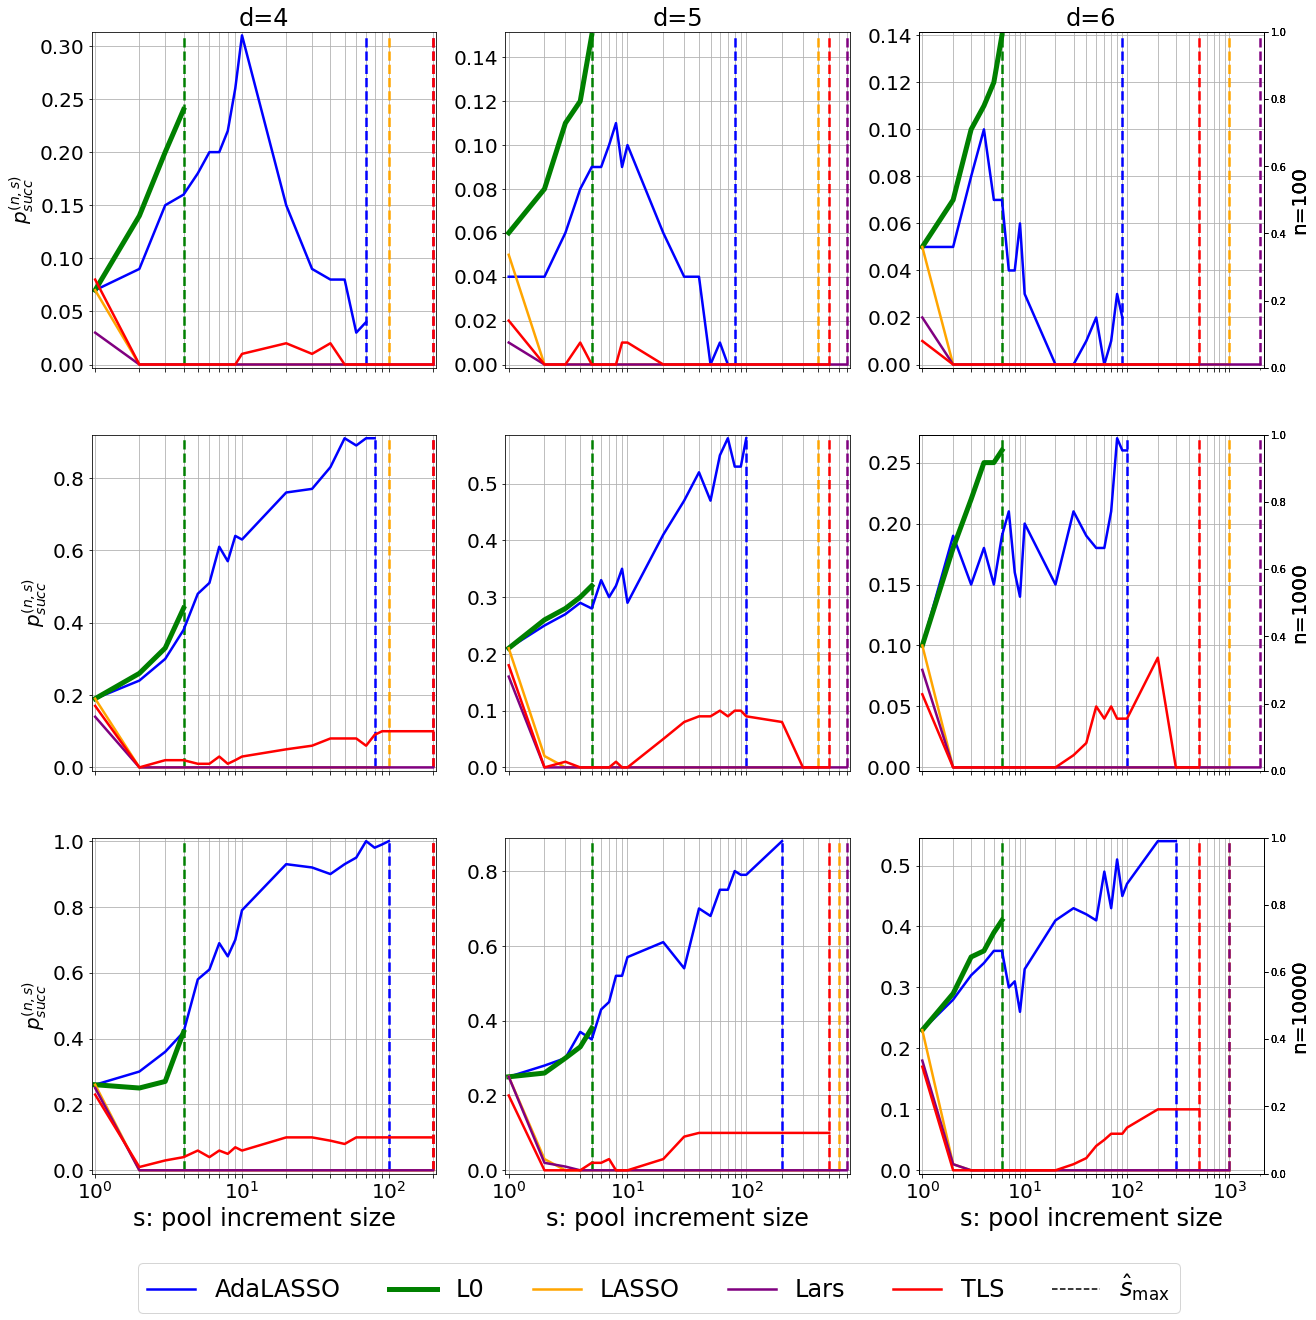

In [ ]:
fig, axs = plot_sis_failure_grid(df=p_df, D=[4,5,6], N=[100,1000,10000], SO=SO)
fig.savefig(os.path.join(out_dir, 'plots', 'SIS_failure_d=[4,5,6]_n=[100,1000,10000].pdf'),  bbox_inches='tight', pad_inches=0)

# Empirically Determined $s_{\max}$

In [48]:
gran = 1000
N_grid = np.logspace(1, 5, gran)
P_grid = np.logspace(1, 6, gran)
K_grid = np.arange(1, 11, 1)
k_c, n_c, p_c = 5, 1000, 100000

knp_c = [k_c, n_c, p_c]

grids = np.zeros(shape = (len(comp_dict.keys()), gran))
grids[0, :len(K_grid)] = K_grid
grids[1, :] = N_grid
grids[2, :] = P_grid

S_grid_ext = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000,2000,3000,4000,5000]

plt_arr = np.zeros(shape = (len(comp_dict.keys()), gran, 3) )
for i, so in enumerate(SO):
    for j, k in enumerate(K_grid):
        plt_arr[i, j, 0] = min(p_c/k + 1, find_s_max(comp_dict[so], c0=c0, c1=c1, k=k, n=n_c, p=p_c, S_grid = S_grid_ext))
    for j, n in enumerate(N_grid):
        plt_arr[i, j, 1] = min(p_c/k_c + 1, find_s_max(comp_dict[so], c0=c0, c1=c1, k=k_c, n=n, p=p_c, S_grid = S_grid_ext))
    for j, p in enumerate(P_grid):
        plt_arr[i, j, 2] = min(p/k_c + 1, find_s_max(comp_dict[so], c0=c0, c1=c1, k=k_c, n=n_c, p=p, S_grid = S_grid_ext))

In [49]:
SO

array(['AdaLASSO(gamma=1)', 'L0', 'LASSO', 'Lars', 'TLS'], dtype=object)

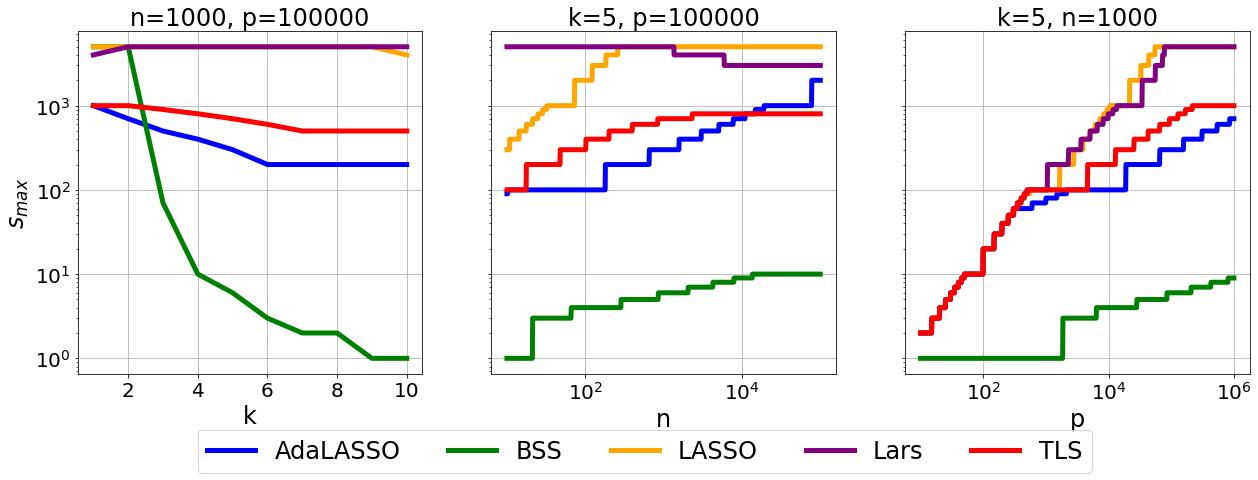

In [ ]:
dim = 3
adj = 0
fig, axs = plt.subplots(1, dim, sharex=False, sharey=True)
fig.set_figheight((plot_size+adj)+vbuffer)
fig.set_figwidth((plot_size+adj)*dim+hbuffer)


for i, so in enumerate(SO):
    label = ('BSS' if so == 'L0' else str(so)) if so!='AdaLASSO(gamma=1)' else 'AdaLASSO'
    for j in range(dim):
        title = 'k={0}, '.format(k_c)*(j!=0) + 'n={0}'.format(n_c)*(j!=1) + ', '*(j==0) + 'p={0}'.format(p_c)*(j!=2)
        if j == 0:
            if not(so in ['TLS', 'Lars']):
                axs[j].plot(grids[j, :len(K_grid)], plt_arr[i, :len(K_grid), j], c=C_DICT[so], label=label, lw=lw)
            else:
                axs[j].plot(grids[j, :len(K_grid)], plt_arr[i, :len(K_grid), j], c=C_DICT[so], lw=lw)
        elif j == 1:
            if so in ['TLS', 'Lars']:
                axs[j].plot(grids[j, :], plt_arr[i, :, j], c=C_DICT[so], label=label, lw=lw)
            else:
                axs[j].plot(grids[j, :], plt_arr[i, :, j], c=C_DICT[so], lw=lw)
        else:
            axs[j].plot(grids[j, :], plt_arr[i, :, j], c=C_DICT[so], label=label, lw=lw)
        axs[j].set_title(title, size=fontsize)

for i in range(dim):
    axs[i].set_xlabel('knp'[i], size=fontsize)
    axs[i].grid()
    axs[i].set_yscale('log')
    if i != 0:
        axs[i].set_xscale('log')
    axs[i].tick_params(axis='both',  labelsize=fontsize-4)

axs[0].set_ylabel(r'$s_{max}$', size=fontsize)        
if out_legend:
#    lines_labels = [axs[i].get_legend_handles_labels() for i in range(dim)]
    lines_labels = [axs[2].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, loc = 'lower center', 
                ncol = 5, fontsize=fontsize, bbox_to_anchor=(0.5, -0.02))
    plt.subplots_adjust(bottom=0.2)
else:
    axs[0].legend(fontsize=fontsize)
    axs[1].legend(fontsize=fontsize)
    axs[2].legend(fontsize=fontsize)


fig.savefig(os.path.join(out_dir, 'plots', 's_max_comparison.pdf'))

# Cross Validation Plot

In [81]:
cv_dir = os.path.join(out_dir, 'Polynomial_CV_Exps')
    
for root, dirs, files in os.walk(cv_dir):
    for i, f in enumerate(files):
        path = os.path.join(cv_dir, f)
        if not('cv_d_4_' in f):
            df_i = pd.read_csv(path)
            print(f, len(df_i))
            if i == 0:
                df_cv = df_i
            else:
                df_cv = df_cv.append(df_i, ignore_index=True)


polynomial_cv_d4_ada_las_bss.csv 409199
additional_so_d=4_folds=[10].csv 412400


In [71]:
def gen_cv_df_summary(df_cv=df_cv,
                      RS = range(10),
                      REPS = range(10)):

    summary_df = pd.DataFrame()
    for i, so in enumerate(SO):
        df_rel = df_cv[(df_cv['f']==10)&(df_cv['d']==4)&(df_cv['so']==so)]

        for j, n in enumerate(N):
            print(so, n)
            df_rel_n = df_rel[df_rel['n']==n]
            for random_state in RS:
                df_rel_n_rs = df_rel_n[df_rel_n['random_state']==random_state]
                for rep in REPS:
                    df_rel_n_rs_rep = df_rel_n_rs[df_rel_n_rs['rep']==rep]
                    S = df_rel_n_rs_rep['s'].unique()
                    s_max = find_s_max(comp_dict[so], c0=c0, c1=c1, k=5, n=n, p=1000)
                    row = {
                        'so': so,
                        'n': n,
                        'random_state': random_state,
                        'rep': rep,
                        's_max': s_max,
                        's_cv': 1,
                        'p_cv': 0,
                    }

                    for i, s in enumerate(S[S<=s_max]):
                        df_rel_n_rs_rep_s = df_rel_n_rs_rep[df_rel_n_rs_rep['s']==s]
                        df_fin = df_rel_n_rs_rep_s[['p0', 'p', 'n', 'k', 'r', 'd', 'random_state', 'rep', 's', 'so',  'inclusion', 'fit_time', 'f_i']].iloc[:10]
                        p_cv = df_fin['inclusion'].mean()
                        if p_cv > row['p_cv']:
                            row['p_cv'] = p_cv
                            row['s_cv'] = s
                    summary_df = summary_df.append(row, ignore_index=True)
    return summary_df 

cv_summary_df = gen_cv_df_summary()

AdaLASSO(gamma=1) 10.0
AdaLASSO(gamma=1) 20.0
AdaLASSO(gamma=1) 50.0
AdaLASSO(gamma=1) 100.0
AdaLASSO(gamma=1) 200.0
AdaLASSO(gamma=1) 500.0
AdaLASSO(gamma=1) 1000.0
AdaLASSO(gamma=1) 2000.0
AdaLASSO(gamma=1) 5000.0
AdaLASSO(gamma=1) 10000.0
L0 10.0
L0 20.0
L0 50.0
L0 100.0
L0 200.0
L0 500.0
L0 1000.0
L0 2000.0
L0 5000.0
L0 10000.0
LASSO 10.0
LASSO 20.0
LASSO 50.0
LASSO 100.0
LASSO 200.0
LASSO 500.0
LASSO 1000.0
LASSO 2000.0
LASSO 5000.0
LASSO 10000.0
Lars 10.0
Lars 20.0
Lars 50.0
Lars 100.0
Lars 200.0
Lars 500.0
Lars 1000.0
Lars 2000.0
Lars 5000.0
Lars 10000.0
TLS 10.0
TLS 20.0
TLS 50.0
TLS 100.0
TLS 200.0
TLS 500.0
TLS 1000.0
TLS 2000.0
TLS 5000.0
TLS 10000.0


In [73]:
oracle_df_d4 = oracle_df[oracle_df['d']==4]
df_plot_cv = pd.DataFrame()
for i, row in cv_summary_df.iterrows():
    oracle_rel = oracle_df_d4[(oracle_df_d4['so']==row['so'])&
            (oracle_df_d4['n']==row['n'])&
            (oracle_df_d4['random_state']==row['random_state'])&
            (oracle_df_d4['rep']==row['rep'])]
    p_cv_refit = oracle_rel[oracle_rel['s']==row['s_cv']]['inclusion'].values
    s_max = row['s_max']
    S = oracle_rel['s'].unique()
    s_star, inc_star = 1, 0
    for j, s in enumerate(S[S<=s_max]):
        inc = oracle_rel[oracle_rel['s']==s]['inclusion'].values[0]
        if inc > inc_star:
            s_star, inc_star = s, inc
    row['s_star'] = s_star
    row['p_oracle'] = inc_star
    df_plot_cv = df_plot_cv.append(row, ignore_index=True)
    if i % 1000 == 0: print(i, len(cv_summary_df))

0 5000
1000 5000
2000 5000
3000 5000
4000 5000


In [74]:
df_plot_cv.to_csv('d4_cv_summary.csv')
df_plot_cv.columns

Index(['so', 'n', 'random_state', 'rep', 's_max', 's_cv', 'p_cv', 's_star',
       'p_oracle'],
      dtype='object')

In [75]:
df_plot_cv_summary = pd.DataFrame()
for i, so in enumerate(df_plot_cv['so'].unique()):
    for j, n in enumerate(df_plot_cv['n'].unique()):
        row = df_plot_cv[(df_plot_cv['so']==so)&(df_plot_cv['n']==n)].mean()
        row['so'] = so
        df_plot_cv_summary = df_plot_cv_summary.append(row, ignore_index=True)
df_plot_cv_summary = df_plot_cv_summary.drop(columns=['random_state', 'rep'])
df_plot_cv_summary.head()

,n,s_max,s_cv,p_cv,s_star,p_oracle,so
0,10.0,70.0,5.30,0.1468,18.89,0.268,AdaLASSO(gamma=1)
1,20.0,70.0,9.47,0.3120,19.25,0.428,AdaLASSO(gamma=1)
2,50.0,70.0,10.56,0.5242,18.41,0.690,AdaLASSO(gamma=1)
3,100.0,70.0,12.74,0.6996,20.51,0.866,AdaLASSO(gamma=1)
4,200.0,70.0,13.61,0.8248,27.11,0.940,AdaLASSO(gamma=1)


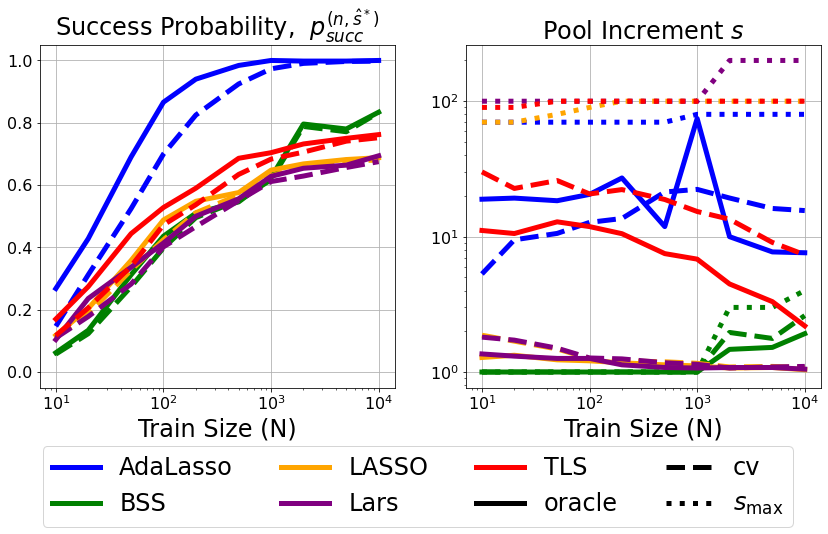

In [ ]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False)
fig.set_figheight(plot_size+vbuffer)
fig.set_figwidth(plot_size*len(axs)+hbuffer)

for i, so in enumerate(df_plot_cv_summary['so'].unique()):
    df_rel = df_plot_cv_summary[df_plot_cv_summary['so']==so]
    N = df_rel['n'].unique()
    label = 'AdaLasso' if so == 'AdaLASSO(gamma=1)' else ('BSS' if so == 'L0' else so)
    axs[0].plot(N, df_rel['p_oracle'], ls=ls[0], lw=lw, label=label, c=C_DICT[so])
    axs[0].plot(N, df_rel['p_cv'], ls=ls[1], lw=lw, c=C_DICT[so])
    axs[1].plot(N, df_rel['s_star'], ls=ls[0], lw=lw, c=C_DICT[so])
    axs[1].plot(N, df_rel['s_cv'], ls=ls[1], lw=lw, c=C_DICT[so])
    axs[1].plot(N, df_rel['s_max'], ls='dotted', lw=lw, c=C_DICT[so])


axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[0].tick_params(axis='both', labelsize=fontsize-8)
axs[1].tick_params(axis='both', labelsize=fontsize-8)
axs[0].grid()
axs[1].grid()


axs[0].set_xlabel('Train Size (N)', fontsize=fontsize)
axs[1].set_xlabel('Train Size (N)', fontsize=fontsize)

axs[0].set_title('Success Probability,  ' + r'$p_{succ}^{(n, \hat{s}^*)}$', fontsize=fontsize)
axs[1].set_title('Pool Increment ' + r'$s$', fontsize=fontsize)

axs[0].plot(N[0], [0], ls='solid', label='oracle', c='k', lw=lw)
axs[0].plot(N[0], [0], ls='dashed', label='cv', c='k', lw=lw)
axs[0].plot(N[0], [0], ls='dotted', label=r'$s_{\max}$', c='k', lw=lw)

if out_legend:
#    lines_labels = [axs[i].get_legend_handles_labels() for i in range(dim)]
    lines_labels = [axs[0].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, loc = 'lower center', 
                ncol = 4, fontsize=fontsize, bbox_to_anchor=(0.5, -0.1))
    plt.subplots_adjust(bottom=0.2)
else:
    axs[0].legend(fontsize=fontsize)
    axs[1].legend(fontsize=fontsize)

fig.savefig(os.path.join(out_dir, 'plots', 'cv_plot_d4.pdf'), bbox_inches="tight")

# Dataset Results

In [5]:
DATA_DICT = {
    'bulk_modulus': {
        'f': 'data_bulk_modulus.csv',
        'drop_cols': ['material', 'A', 'B1', 'B2'],
        'target': 'bulk_modulus (eV/AA^3)'
    },
    'bandgap': {
        'f': 'data_bandgap.csv',
        'drop_cols': ['material'],
        'target': 'bg_hse06 (eV)'
    },
    'yield': {
        'f': 'data_HTE.csv',
        'drop_cols': ['material_and_condition'],
        'target': 'Y_oxygenate'
    },
    'diabetes': {
        'f': 'diabetes.csv',
        'drop_cols': [],
        'target': 'Y'
    },
    'eye': {
        'f': 'eye.csv',
        'drop_cols': [],
        'target': 'y'
    },
    'facebook': {
        'f': 'facebook.csv',
        'drop_cols': ['Type'],
        'target': 'Total.Interactions'
    },
    'realEstate': {
        'f': 'realEstate.csv',
        'drop_cols': [],
        'target': 'Y'
    },    
    'ribo': {
        'f': 'ribo.csv',
        'drop_cols': [],
        'target': 'Y'
    },    
    'concrete': {
        'f': 'concrete.csv',
        'drop_cols': [],
        'target': 'Strength'
    },    
    'yacht': {
        'f': 'BByacht.csv',
        'drop_cols': [],
        'target': 'V7'
    },   
    'conditionTur': {
        'f': 'conditionTur.csv',
        'drop_cols': [],
        'target': 'gt_t_decay'
    },   
    'airfoil': {
        'f': 'airfoil.csv',
        'drop_cols': [],
        'target': 'V6'
    },   
    'autompg': {
        'f': 'autompg.csv',
        'drop_cols': [],
        'target': 'mpg'
    }, 
   'parkinson_total': {
        'f': 'Bparkinson_total.csv',
        'drop_cols': [],
        'target': 'total_UPDRS'
    }, 
    'parkinson_motor': {
        'f': 'parkinson_motor.csv',
        'drop_cols': [],
        'target': 'motor_UPDRS'
    }, 
}

dataset_keys = list(DATA_DICT.keys())

File_names =['Dataset_Exps/output_{0}_opt_k_True.csv'.format(data_key) 
              for i, data_key in enumerate(dataset_keys)]    
predict_mean_df = pd.read_csv(os.path.join(out_dir, 'Dataset_Exps/predict_mean_output.csv'))     
              
data_res_df = pd.DataFrame()
for i, f in enumerate(File_names):
    df_i_j = pd.read_csv(os.path.join(out_dir, f))
    data_res_df = data_res_df.append(df_i_j, ignore_index=True)
    print(f)

data_res_df['train_rmse'] = np.sqrt(data_res_df['sse_train']/data_res_df['n'])
data_res_df['test_rmse'] = np.sqrt(data_res_df['sse_test']/data_res_df['n'])
fit_time_total_hrs = np.round(data_res_df['fit_time'].replace([np.inf,-np.inf], 0).sum()/3600, 3)
RS_total = len(data_res_df['random_state'].unique())
num_datasets = len(data_res_df['problem'].unique())
print('It took {0} hours to perform {1} repetitions on {2} datasets'.format(fit_time_total_hrs, RS_total, num_datasets))

Dataset_Exps/output_bulk_modulus_opt_k_True.csv
Dataset_Exps/output_bandgap_opt_k_True.csv
Dataset_Exps/output_yield_opt_k_True.csv
Dataset_Exps/output_diabetes_opt_k_True.csv
Dataset_Exps/output_eye_opt_k_True.csv
Dataset_Exps/output_facebook_opt_k_True.csv
Dataset_Exps/output_realEstate_opt_k_True.csv
Dataset_Exps/output_ribo_opt_k_True.csv
Dataset_Exps/output_concrete_opt_k_True.csv
Dataset_Exps/output_yacht_opt_k_True.csv
Dataset_Exps/output_conditionTur_opt_k_True.csv
Dataset_Exps/output_airfoil_opt_k_True.csv
Dataset_Exps/output_autompg_opt_k_True.csv
Dataset_Exps/output_parkinson_total_opt_k_True.csv
Dataset_Exps/output_parkinson_motor_opt_k_True.csv
It took 93.722 hours to perform 100 repetitions on 15 datasets


In [7]:
models_used = data_res_df['so'].unique()
datasets = data_res_df['problem'].unique()
metrics = ['RMSE', 'Complexity', 'Fit Time']

for i, data_key in enumerate(dataset_keys):
    f, drop_cols, target = DATA_DICT[data_key]['f'], DATA_DICT[data_key]['drop_cols'], DATA_DICT[data_key]['target']
    df_bm = pd.read_csv(os.path.join(os.getcwd(), 'icol_exp', 'Input', f))
    y = df_bm[target]
    X = df_bm.drop(columns=[target]+drop_cols)
    names = X.columns
    X = X.values
    count=0
    for i, name1 in enumerate(names):
        for j, name2 in enumerate(names):
            if i!=j and name1 in name2:
                count+=1
    DATA_DICT[data_key]['raw_inputs'] = names
    print(data_key, count)

FileNotFoundError: [Errno 2] No such file or directory: '/home/simon/Documents/Research/icol/icol_exp/Input/data_bulk_modulus.csv'

In [61]:
ops = ['sin', 'cos', 'log', 'exp', 'Abs', '^', '*', '/', '+', '-', '\n']
complexity = np.empty(shape=len(data_res_df))
k_hat = np.empty(shape=len(data_res_df))
for i in range(len(data_res_df)):
    mstring = data_res_df.iloc[i]['model'].replace('**', '^')
    k_hat[i] = mstring.count('\n')
    terms = [''.join(term.split(' ')[1:]) for term in mstring.split('\n')]
    mstring = ''.join(terms)
    c = 2*len(terms) - 1
    raw_inputs = DATA_DICT[data_res_df.iloc[i]['problem']]['raw_inputs']
    for op in ops:
        op_c = mstring.count(op)
        c += op_c
    for ri in raw_inputs:
        ri_c = mstring.count(ri)
        c += ri_c
    complexity[i] = c
data_res_df['complexity'] = complexity
data_res_df['k_hat'] = k_hat
data_res_df['r2'] = 1 - (data_res_df['sse_test']/data_res_df['tss_test'])
print(data_res_df['r2'].head())

0    0.529323
1    0.529323
2    0.492144
3    0.342453
4    0.492144
Name: r2, dtype: float64


In [62]:
predict_mean_df['complexity'] = 1
predict_mean_df['k_hat'] = 0
predict_mean_df['r2'] = 1 - (predict_mean_df['sse_test']/predict_mean_df['tss_test'])
print(predict_mean_df['r2'].head())

0   -0.000002
1   -0.000098
2   -0.000541
3   -0.000226
4   -0.003622
Name: r2, dtype: float64


In [63]:
min(predict_mean_df['r2'])

-1.0119744764273166

In [64]:
dataset_summary = pd.DataFrame() 
se = lambda x, z=1: z*np.std(x) / np.sqrt(len(x))
SO_DF = data_res_df['so'].unique()

metric = 'r2'
for i, dataset in enumerate(datasets):
    N_DS = data_res_df[data_res_df['problem']==dataset]['n'].unique()
    p = int(data_res_df[data_res_df['problem']==dataset]['p'].unique())
    for j, n in enumerate(N_DS):
        for k, so in enumerate(SO_DF):
            print(dataset, n, so)
            s_max = find_s_max(comp_dict[so], c0=c0, c1=c1, k=5, n=n, p=p)
            rel_df = data_res_df[(data_res_df['problem']==dataset)&
                                 (data_res_df['n']==n)&
                                 (data_res_df['so']==so)]
            RS = rel_df['random_state'].unique()
            S_STAR_ARR, E_STAR_ARR, FIT_TIME_ARR, COMP_ARR, K_ARR = np.zeros(shape=len(RS)), np.zeros(shape=len(RS)), np.zeros(shape=len(RS)), np.zeros(shape=len(RS)), np.zeros(shape=len(RS))
            for random_state in RS:

                rs_df = rel_df[rel_df['random_state']==random_state]
                S = rel_df['s'].unique()
                S_rel = S[S<=s_max]
                if metric == 'r2':
                    pm_err = float(predict_mean_df[(predict_mean_df['problem']==dataset)&(predict_mean_df['random_state']==random_state)]['r2'].values)
                elif metric == 'test_rmse':
                    pm_err = float(predict_mean_df[(predict_mean_df['problem']==dataset)&(predict_mean_df['random_state']==random_state)]['test_rmse'].values)
                
                s_star, e_star, comp, fit_time, k_hat_star = 0, pm_err, 1, np.infty, 0

                for l, s in enumerate(S_rel):
                    if metric == 'test_rmse':
                        e = float(rs_df[rs_df['s']==s]['test_rmse'].values)
                    elif metric == 'r2':
                        e = float(rs_df[rs_df['s']==s]['r2'].values)

                    c = float(rs_df[rs_df['s']==s]['complexity'].values)
                    ft = float(rs_df[rs_df['s']==s]['fit_time'].values)
                    kh = float(rs_df[rs_df['s']==s]['k_hat'].values)
                    if (metric == 'test_rmse') and e<e_star:
                        s_star, e_star, comp, fit_time, k_hat_star = s, e, c, ft, kh
                    elif (metric == 'r2') and e>e_star:
                        s_star, e_star, comp, fit_time, k_hat_star = s, e, c, ft, kh
                S_STAR_ARR[int(random_state)] = s_star
                E_STAR_ARR[int(random_state)] = e_star
                COMP_ARR[int(random_state)] = comp
                FIT_TIME_ARR[int(random_state)] = fit_time
                K_ARR[int(random_state)] = k_hat_star
            row = {'problem': dataset, 
                   'n': n,
                   'so': so,
                   's_max': s_max,
                   's_hat_star': S_STAR_ARR.mean(),
                   'EmpRisk': E_STAR_ARR.mean(), 
                   'Complexity': COMP_ARR.mean(), 
                   'Fit Time': FIT_TIME_ARR.mean(), 
                   'k_hat': K_ARR.mean(), 
                   's_hat_star_se': se(S_STAR_ARR),
                   'EmpRisk_se': se(E_STAR_ARR), 
                   'Complexity_se': se(COMP_ARR), 
                   'Fit Time_se': se(FIT_TIME_ARR),
                   'k_hat_se': se(K_ARR)
            }
            dataset_summary = dataset_summary.append(row, ignore_index=True)           


bulk_modulus 4583.0 LASSO
bulk_modulus 4583.0 AdaptiveLASSO
bulk_modulus 4583.0 BSS
bulk_modulus 4583.0 LARS
bulk_modulus 4583.0 TLS
bandgap 3091.0 LASSO
bandgap 3091.0 AdaptiveLASSO
bandgap 3091.0 BSS
bandgap 3091.0 LARS
bandgap 3091.0 TLS
yield 1220.0 LASSO
yield 1220.0 AdaptiveLASSO
yield 1220.0 BSS
yield 1220.0 LARS
yield 1220.0 TLS
diabetes 442.0 LASSO
diabetes 442.0 AdaptiveLASSO
diabetes 442.0 BSS
diabetes 442.0 LARS
diabetes 442.0 TLS
eye 120.0 LASSO
eye 120.0 AdaptiveLASSO
eye 120.0 BSS
eye 120.0 LARS
eye 120.0 TLS
facebook 495.0 LASSO
facebook 495.0 AdaptiveLASSO
facebook 495.0 BSS
facebook 495.0 LARS
facebook 495.0 TLS
realEstate 414.0 LASSO
realEstate 414.0 AdaptiveLASSO
realEstate 414.0 BSS
realEstate 414.0 LARS
realEstate 414.0 TLS
ribo 71.0 LASSO
ribo 71.0 AdaptiveLASSO
ribo 71.0 BSS
ribo 71.0 LARS
ribo 71.0 TLS
concrete 1030.0 LASSO
concrete 1030.0 AdaptiveLASSO
concrete 1030.0 BSS
concrete 1030.0 LARS
concrete 1030.0 TLS
yacht 308.0 LASSO
yacht 308.0 AdaptiveLASSO
yach

In [65]:
plotting = False
if plotting:

    from matplotlib.ticker import MaxNLocator
    from matplotlib.ticker import LogLocator

    fig, axs = plt.subplots(len(datasets), len(metrics), sharex='row', sharey=False)
    fig.set_figheight(len(datasets)*plot_size + vbuffer)
    fig.set_figwidth(len(metrics)*plot_size + hbuffer)

    ebar = False
    metrics = ['EmpRisk', 'Complexity', 'Fit Time']

    for i, dataset in enumerate(datasets):
        N_DF = dataset_summary[dataset_summary['problem']==dataset]['n'].unique()
        for j, metric in enumerate(metrics):
            for l, so in enumerate(SO_DF):
                y = dataset_summary[(dataset_summary['problem']==dataset)&
                                (dataset_summary['so']==so)][metric].values
                err = dataset_summary[(dataset_summary['problem']==dataset)&
                                (dataset_summary['so']==so)][metric+'_se'].values 
                if ebar:           
                    axs[i, j].errorbar(N_DF, y, yerr=err, label=so, c=C_DICT[so], lw=lw, ls=ls[0])
                else:
                    axs[i, j].plot(N_DF, y, label=so, c=C_DICT[so], lw=lw, ls=ls[0])

            if metric != 'Complexity':
                axs[i,j].set_yscale('log')
                axs[i,j].yaxis.set_major_locator(LogLocator(base=10, numticks=5))
            else:
                axs[i,j].yaxis.set_major_locator(MaxNLocator(nbins=5))
                axs[i,j].tick_params(axis='both', labelsize=fontsize-8)

            axs[i,j].tick_params(axis='y', labelsize=fontsize-8)

            axs[i,j].grid()

    for i in range(len(metrics)):
        axs[-1, i].set_xlabel('Train Size (n)', fontsize=fontsize)
        axs[0, i].set_title(metrics[i], fontsize=fontsize)
    for i, data_key in enumerate(datasets):
        axs[i, 0].set_ylabel(data_key, fontsize=fontsize)


    if out_legend:
    #    lines_labels = [axs[i].get_legend_handles_labels() for i in range(dim)]
        lines_labels = [axs[0, 0].get_legend_handles_labels()]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
        fig.legend(lines, labels, loc = 'lower center', 
                    ncol = 5, fontsize=fontsize, bbox_to_anchor=(0.5, 0))
        plt.subplots_adjust(bottom=0.1)
    else:
        axs[0].legend(fontsize=fontsize)
        axs[1].legend(fontsize=fontsize)
    fig.savefig('Dataset_exp_opt_k_True.pdf')

## FastRidge $r^2$

In [8]:
ridge_summary = pd.DataFrame() 
fastridge_values = pd.DataFrame()
def fmt(x):
    """Format x with 3 decimals and no leading zero."""
    return f"{x:.3f}".lstrip("0")

f_fastridge ='Dataset_Exps/fastridge_output.csv'
fastridge_df = pd.read_csv(os.path.join(out_dir, f_fastridge))

fastridge_df['train_rmse'] = np.sqrt(fastridge_df['sse_train']/fastridge_df['n'])
fastridge_df['test_rmse'] = np.sqrt(fastridge_df['sse_test']/fastridge_df['n'])
fastridge_df['r2'] = 1 - (fastridge_df['sse_test']/fastridge_df['tss_test'])
se = lambda x, z=1: z*np.std(x) / np.sqrt(len(x))

metric = 'r2'
for i, dataset in enumerate(datasets):
    ERR = fastridge_df[(fastridge_df['problem']==dataset)][metric]
    r2 = ERR.mean()
    se = ERR.std()/np.sqrt(len(ERR))
    label = rf"${fmt(r2)}\,{{\scriptstyle \pm {fmt(1.96*se)}}}$"
    row = {'Dataset': dataset, 'FastRidge': label}
    ridge_summary = ridge_summary.append(row, ignore_index=True)  
    val_row = {'Dataset': dataset, 'r2': r2, 'se': se}
    fastridge_values = fastridge_values.append(val_row, ignore_index=True)


latex_table = ridge_summary.to_latex(
    index=False,             
    caption="Summary table for 5 base estimators on various datasets",
    label="tab:dataset_table",
    escape=False,              # set False if you have LaTeX in your data
)

with open("datasets_summary.tex", "w") as f:
    f.write(latex_table)

ridge_summary

,Dataset,FastRidge
0,bulk_modulus,"$.630\,{\scriptstyle \pm .002}$"
1,bandgap,"$.929\,{\scriptstyle \pm .001}$"
2,yield,"$.123\,{\scriptstyle \pm .005}$"
3,diabetes,"$.476\,{\scriptstyle \pm .009}$"
4,eye,"$.285\,{\scriptstyle \pm .059}$"
5,facebook,"$.890\,{\scriptstyle \pm .017}$"
6,realEstate,"$.550\,{\scriptstyle \pm .012}$"
7,ribo,"$.605\,{\scriptstyle \pm .021}$"
8,concrete,"$.601\,{\scriptstyle \pm .005}$"
9,yacht,"$.969\,{\scriptstyle \pm .002}$"


## ICL $r^2$

In [68]:
cols = ['EmpRisk', 'EmpRisk_se']
latex_df_so = pd.DataFrame()
values_df_so = pd.DataFrame()
for i, dataset in enumerate(datasets):
    data_res_df[data_res_df['problem']==dataset]
    N_DF = dataset_summary[dataset_summary['problem']==dataset]['n'].unique()
    max_n = max(N_DF)
    row = {
        'Dataset': dataset, 
    }
    row_vals = {
        'Dataset': dataset,
    }    
    rel_df = dataset_summary[(dataset_summary['problem']==dataset)&(dataset_summary['n']==max_n)]
    for j, so in enumerate(SO_DF):
        summary_table_ds = rel_df[rel_df['so']==so][cols].add_suffix('_'+so)
        r2 = np.round(float(summary_table_ds['EmpRisk_'+so]), 3)
        se = np.round(float(summary_table_ds['EmpRisk_se_'+so]), 3)
        label = rf"${fmt(r2)}\,{{\scriptstyle \pm {fmt(1.96*se)}}}$"
        row[so] = label
        row_vals[so] = r2
        row_vals[so+'_se'] = se
    latex_df_so = latex_df_so.append(row, ignore_index=True)
    values_df_so = values_df_so.append(row_vals, ignore_index=True)

def analyze_row(row, SOs = SO_DF):
    means = np.array([row[f"{i}"] for i in SO_DF])
    ses   = np.array([row[f"{i}_se"] for i in SO_DF])
    
    # Confidence intervals
    lower = means - 1.96 * ses
    upper = means + 1.96 * ses
    
    # Best methods
    best_value = means.max()
    best_methods = [i for i, m in enumerate(means) if m == best_value]
    
    # Overlap checks with the first best method (or all if tied)
    j = best_methods[0]  # index of first best
    L_best, U_best = lower[j], upper[j]
    
    overlaps = {
        '{0}'.format(SOs[i]): not (upper[i-1] < L_best or lower[i-1] > U_best)
        for i in range(len(SOs))
        if i != best_methods[0]
    }
        
    overlaps = [
        SO[i] 
        for i in range(len(SOs))
        if (i != best_methods[0]) and (not (upper[i-1] < L_best or lower[i-1] > U_best))
    ]

    return pd.Series({
        "best_methods": [SOs[i] for i in best_methods],
        "best_CI_lower": L_best,
        "best_CI_upper": U_best,
        "overlaps": overlaps
    })

def analyze_row_best_models(
    row: pd.Series,
    # model_names,
    se_suffix: str = "_se",
    z: float = 1.96,
    atol: float = 1e-12,
    rtol: float = 1e-9,
):
    """
    model_names: list of model column base names, e.g. ["m1","m2","m3","m4","m5"]
                 expects columns: <name> and <name>_se (or se_suffix)
    """
    # model_names = list(model_names)
    model_names = list(SO_DF)

    means = row[model_names].to_numpy(dtype=float)
    ses   = row[[f"{m}{se_suffix}" for m in model_names]].to_numpy(dtype=float)

    lower = means - z * ses
    upper = means + z * ses

    best_value = np.nanmax(means)
    best_mask = np.isclose(means, best_value, atol=atol, rtol=rtol)
    best_idx = np.where(best_mask)[0]
    best_models = [model_names[i] for i in best_idx]

    # If tie for best mean, automatically weak winners
    if len(best_idx) > 1:
        return pd.Series({
            "best_mean": best_value,
            "winner_strength": "weak",           # by your rule
            "strong_winners": [],
            "weak_winners": best_models,         # tied best
            "best_models": best_models,
            "best_CI_lower": np.nan,             # not unique
            "best_CI_upper": np.nan,             # not unique
            "overlapping_models": [],            # not used in tie case
        })

    # Single best: check CI overlap against all others
    b = int(best_idx[0])
    Lb, Ub = float(lower[b]), float(upper[b])

    def ci_overlaps(i: int) -> bool:
        # overlap if intervals intersect (inclusive)
        return not (upper[i] < Lb or lower[i] > Ub)

    overlapping_idx = [i for i in range(len(model_names)) if i != b and ci_overlaps(i)]
    overlapping_models = [model_names[i] for i in overlapping_idx]

    if overlapping_models:
        # single best mean, but others overlap its CI => weak winner(s)
        return pd.Series({
            "best_mean": best_value,
            "winner_strength": "weak",
            "strong_winners": [],
            "weak_winners": [model_names[b]],
            "best_models": [model_names[b]],
            "best_CI_lower": Lb,
            "best_CI_upper": Ub,
            "overlapping_models": overlapping_models,
        })
    else:
        # single best mean and no overlap => strong winner
        return pd.Series({
            "best_mean": best_value,
            "winner_strength": "strong",
            "strong_winners": [model_names[b]],
            "weak_winners": [],
            "best_models": [model_names[b]],
            "best_CI_lower": Lb,
            "best_CI_upper": Ub,
            "overlapping_models": [],
        })


best_models = values_df_so.apply(analyze_row_best_models, axis=1)
best_models

latex_df_so_copy = latex_df_so.copy()
ridge_summary_copy = ridge_summary.copy()

for i in range(len(latex_df_so)):
    sw = best_models.iloc[i]['strong_winners']
    ww = best_models.iloc[i]['weak_winners']
    # best_models_dataset = best_models.iloc[i]['best_methods']    	
    for best in ww:
        s = latex_df_so.iloc[i][best]
        latex_df_so_copy.iloc[i][best] = r'$\mathbf{' + s[1:-1] + r'}$'

    for best in sw:
        s = latex_df_so.iloc[i][best]
        latex_df_so_copy.iloc[i][best] = r'\underline{$\mathbf{' + s[1:-1] + r'}$}'

for i in range(len(ridge_summary)):
    r2 = float(fastridge_values.iloc[i]["r2"])
    se = float(fastridge_values.iloc[i]["se"])

    sw = best_models.iloc[i]["strong_winners"]
    ww = best_models.iloc[i]["weak_winners"]

    # ridge_win meanings:
    # 0 = Ridge loses to at least one (strong/weak) ICL winner
    # 1 = Ridge is a weak winner (overlaps CI with best ICL)
    # 2 = Ridge is a strong winner (beats best ICL with no overlap)
    ridge_win = 2

    for icl in (sw + ww):
        r2_icl = float(values_df_so.iloc[i][icl])
        se_icl = float(values_df_so.iloc[i][icl + "_se"])

        # If Ridge mean is worse than any compared ICL, it cannot be a winner
        if r2 < r2_icl:
            ridge_win = 0
            break

        # If Ridge doesn't clearly separate (CI overlap condition), downgrade to weak
        if ridge_win > 0 and (r2 >= r2_icl) and ((r2 - 1.96 * se) < (r2_icl + 1.96 * se_icl)):
            ridge_win = 1  # <-- FIXED (was ridgein)

    s = ridge_summary.iloc[i]["FastRidge"]  # expected like "$...$"

    if ridge_win == 1:
        # bold only
        s = r"$\mathbf{" + s[1:-1] + r"}$"
    elif ridge_win == 2:
        # underline + bold (safe, balanced)
        s = r"\underline{$\mathbf{" + s[1:-1] + r"}$}"
    ridge_summary_copy.iloc[i, ridge_summary_copy.columns.get_loc("FastRidge")] = s

merged = pd.merge(ridge_summary_copy, latex_df_so_copy, on="Dataset")


def to_plain_str(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return ""
    if isinstance(x, (np.ndarray, list, tuple)):
        # never abbreviate arrays/lists
        return np.array2string(np.asarray(x), threshold=np.inf, separator=", ")
    return x if isinstance(x, str) else str(x)

merged_fixed = merged.copy()
for c in merged_fixed.columns:
    # only touch object columns
    if merged_fixed[c].dtype == "object":
        merged_fixed[c] = merged_fixed[c].map(to_plain_str)


with pd.option_context("display.max_colwidth", None):
    latex_table = merged_fixed.to_latex(
        index=False,
        longtable=True,
        escape=False,
        column_format="l" * len(merged.columns),
        na_rep="",                 # don't print "nan"
        sparsify=False,
        caption = r'{Mean $r^2$ over 100 repetitions with associated $\%95$ confidence intervals. The ICL Model with the best mean $r^2$ are noted in bold (and cases where there is no other ICL model with an overlapping $\%95$ confidence interval are also underlined). Instances where the Ridge outperformed the best ICL model are noted in bold (and underlined where there is not an overlapping $\%95$ confidence interval).}',
    )

with open("table_of_results.tex", "w") as f:
    f.write(latex_table)

## ICL $k$

## Ops table

In [69]:
all_ops = ['sin', 'cos', 'log', 'abs', 'sqrt', 'cbrt', 'sq', 'cb', 'inv', 'six_pow', 'exp', 'mul', 'abs_diff', 'add', 'div']

FE_DICT = {
    'small_p0': {'rung': 2,
        'small': ['sin', 'cos', 'log', 'abs', 'sqrt', 'cbrt', 'sq', 'cb', 'inv',  'mul'],
        'big': ['exp', 'six_pow', 'abs_diff', 'add', 'div'],
        'data_keys':  ['yacht', 'concrete', 'realEstate', 'diabetes', 'facebook']},
    'med_p0': {'rung': 2,
        'small': ['sin', 'cos', 'log', 'abs', 'sqrt', 'cbrt', 'sq', 'cb', 'inv'],
        'big': ['exp', 'six_pow', 'mul', 'div', 'abs_diff', 'add'],
        'data_keys': ['conditionTur', 'bulk_modulus', 'bandgap', 'yield']},
    'big_p0': {'rung': 1,
        'small': ['sin', 'cos', 'log', 'abs', 'sqrt', 'cbrt', 'sq', 'cb', 'inv',  'mul', 'div', 'abs_diff', 'add', 'exp', 'six_pow'],
        'big': [],
        'data_keys': ['eye']},
    'huge_p0': {'rung': 0,
        'small': [],
        'big': [],
        'data_keys': ['ribo']},
}


cols=['op'] + list(np.array([['rung_1_{0}'.format(col) for col in list(FE_DICT.keys())], ['rung_2_{0}'.format(col) for col in list(FE_DICT.keys())]]).ravel(order='F'))

ops_df = pd.DataFrame(columns=cols)
for i, op in enumerate(all_ops):
    row = {'op': op}
    for j, key in enumerate(FE_DICT.keys()):
        insmall = op in FE_DICT[key]['small']
        inbig = op in FE_DICT[key]['big']
        rung = FE_DICT[key]['rung']
        row['rung_1_{0}'.format(key)] = (insmall or inbig) and rung>0
        row['rung_2_{0}'.format(key)] = (insmall) and rung>1
    ops_df = ops_df.append(row, ignore_index=True)

caption = ','.join(['{0}: {1}'.format(key, FE_DICT[key]['data_keys']) for i, key in enumerate(FE_DICT.keys())]) 

latex_table = ops_df.to_latex(
    index=False,             
    caption=caption,
    label="tab:dataset_table",
    escape=True,              # set False if you have LaTeX in your data
)
with open("ops_table.tex", "w") as f:
    f.write(latex_table)

ops_df

,op,rung_1_small_p0,rung_2_small_p0,rung_1_med_p0,rung_2_med_p0,rung_1_big_p0,rung_2_big_p0,rung_1_huge_p0,rung_2_huge_p0
0,sin,True,True,True,True,True,False,False,False
1,cos,True,True,True,True,True,False,False,False
2,log,True,True,True,True,True,False,False,False
3,abs,True,True,True,True,True,False,False,False
4,sqrt,True,True,True,True,True,False,False,False
5,cbrt,True,True,True,True,True,False,False,False
6,sq,True,True,True,True,True,False,False,False
7,cb,True,True,True,True,True,False,False,False
8,inv,True,True,True,True,True,False,False,False
9,six_pow,True,False,True,False,True,False,False,False


In [70]:
cols = []

dataset_summary_table = pd.DataFrame()
for i, dataset in enumerate(datasets):
    data_res_df[data_res_df['problem']==dataset]
    N_DF = dataset_summary[dataset_summary['problem']==dataset]['n'].unique()
    max_n = max(N_DF)
    row = {
        'Dataset': dataset, 
        r'$n$': max_n,
        r'$p_0$': int(data_res_df[data_res_df['problem']==dataset]['p0'].unique()),
        r'$p$': int(data_res_df[data_res_df['problem']==dataset]['p'].unique()),
        'Target': '',
        'Source': ''
    }    
    rel_df = dataset_summary[(dataset_summary['problem']==dataset)&(dataset_summary['n']==max_n)]
    for j, so in enumerate(SO_DF):
        summary_table_ds = rel_df[rel_df['so']==so][cols].add_suffix('_'+so)
        for l, key in enumerate(summary_table_ds.keys()):
            row[key] = float(summary_table_ds[key])
    dataset_summary_table = dataset_summary_table.append(row, ignore_index=True)


latex_table = dataset_summary_table.to_latex(
    index=False,             
    caption="Summary table for 5 base estimators on various datasets",
    label="tab:dataset_table",
    escape=False,              # set False if you have LaTeX in your data
)
with open("datasets_summary.tex", "w") as f:
    f.write(latex_table)

dataset_summary_table

,Dataset,$n$,$p_0$,$p$,Target,Source
0,bulk_modulus,4583.0,24.0,12103.0,,
1,bandgap,3091.0,24.0,11552.0,,
2,yield,1220.0,11.0,2818.0,,
3,diabetes,442.0,10.0,49911.0,,
4,eye,120.0,200.0,81801.0,,
5,facebook,495.0,14.0,4721.0,,
6,realEstate,414.0,6.0,9062.0,,
7,ribo,71.0,4088.0,4088.0,,
8,concrete,1030.0,8.0,22843.0,,
9,yacht,308.0,6.0,9109.0,,


# AdaLasso failure from parkinsons 

In [71]:
park_mot_ada = data_res_df[(data_res_df['problem']=='parkinson_motor')&(data_res_df['so']=='AdaptiveLASSO')][['random_state', 's', 'r2', 'model', 'k_hat']]
best_model_ala_park = park_mot_ada.loc[park_mot_ada["r2"].idxmax()]['model']
best_r2_ala_park = park_mot_ada.loc[park_mot_ada["r2"].idxmax()]['r2']
print(best_r2_ala_park)
print(best_model_ala_park)

0.43285828426758055
+8.778e+00 (sin(age**3))
-7.284e+00 (sin(age + sex))
+9.403e+00 (log(Shimmer.APQ11*age))
-6.229e+00 (log(Shimmer.APQ11*Shimmer.APQ5))
+3.171e+00 (log(Shimmer.DDA*age))
+-38.652


In [72]:
park_mot_lar = data_res_df[(data_res_df['problem']=='parkinson_motor')&(data_res_df['so']=='LARS')][['random_state', 's', 'r2', 'model', 'k_hat']]
best_model_lar_park = park_mot_lar.loc[park_mot_lar["r2"].idxmax()]['model']
best_r2_lar_park = park_mot_lar.loc[park_mot_lar["r2"].idxmax()]['r2']
print(best_r2_lar_park)
print(best_model_lar_park)

0.49247648614381145
+3.747e+00 (sin(age**2))
+9.464e+00 (sin(age**3))
-6.906e+00 (sin(age*sex))
-4.450e+00 (cos(sqrt(age)))
+2.032e+00 (cos(age**6))
+14.795


# AdaLasso succes from concrete

In [73]:
conc_ada = data_res_df[(data_res_df['problem']=='concrete')&(data_res_df['so']=='AdaptiveLASSO')][['random_state', 's', 'r2', 'model', 'k_hat']]
best_model_ala_conc = conc_ada.loc[conc_ada["r2"].idxmax()]['model']
best_r2_ala_conc = conc_ada.loc[conc_ada["r2"].idxmax()]['r2']
print(best_r2_ala_conc)
print(best_model_ala_conc)

0.8272103351896917
+1.757e-02 (Cement*log(Age))
-1.051e-09 (Fine.Aggregate*Water*(Coarse.Aggregate + Water))
+1.591e-04 (Cement*Fly.Ash**(1/3)/Age)
+3.914e-05 (Blast.Furnace.Slag*log(Age)/Fine.Aggregate)
+1.957e-06 (sqrt(Cement)*Coarse.Aggregate/Fine.Aggregate)
+12.807


In [74]:
conc_tls = data_res_df[(data_res_df['problem']=='concrete')&(data_res_df['so']=='TLS')][['random_state', 's', 'r2', 'model', 'k_hat']]
best_model_tls_conc = conc_tls.loc[conc_tls["r2"].idxmax()]['model']
best_r2_tls_conc = conc_tls.loc[conc_tls["r2"].idxmax()]['r2']
print(best_r2_tls_conc)
print(best_model_tls_conc)

0.8272103351896918
+1.757e-02 (Cement*log(Age))
+1.591e-04 (Age*Cement*Fly.Ash**(1/3))
+1.957e-06 (sqrt(Cement)*Abs(Coarse.Aggregate - Fine.Aggregate))
-1.051e-09 (Fine.Aggregate*Water*(Coarse.Aggregate + Water))
+3.914e-05 ((Blast.Furnace.Slag + Fine.Aggregate)*log(Age))
+12.807


# AdaLasso succes from ribo

In [75]:
ribo_ada = data_res_df[(data_res_df['problem']=='ribo')&(data_res_df['so']=='AdaptiveLASSO')][['random_state', 's', 'r2', 'model', 'k_hat']]
best_model_ala_ribo = ribo_ada.loc[ribo_ada["r2"].idxmax()]['model']
best_r2_ala_ribo = ribo_ada.loc[ribo_ada["r2"].idxmax()]['r2']
print(best_r2_ala_ribo)
print(best_model_ala_ribo)

0.8207309635169142
-3.204e-01 (ARGF_at)
+4.064e-01 (XHLB_at)
-5.347e-02 (YCDH_at)
-1.325e+00 (YOAB_at)
-3.468e-01 (YXLE_at)
+5.812


In [76]:
ribo_tls = data_res_df[(data_res_df['problem']=='ribo')&(data_res_df['so']=='TLS')][['random_state', 's', 'r2', 'model', 'k_hat']]
best_model_tls_ribo = ribo_tls.loc[ribo_tls["r2"].idxmax()]['model']
best_r2_tls_ribo = ribo_tls.loc[ribo_tls["r2"].idxmax()]['r2']
print(best_r2_tls_ribo)
print(best_model_tls_ribo)

0.7839792351909163
-2.271e-01 (ARGF_at)
+4.015e-01 (XHLA_at)
-1.364e+00 (YOAB_at)
-4.330e-01 (YXLG_at)
+5.995


In [77]:
ribo_tls['k_hat'].mean(), ribo_ada['k_hat'].mean()

(2.27, 2.971764705882353)

In [78]:
park_mot_lar['k_hat'].mean(), park_mot_ada['k_hat'].mean()

(3.6585185185185187, 2.7465)